In [107]:
# Number of tests in folder
nTests = 20
testNames_base = ["leastAllocated", "mostAllocated", "requestedToCapacityRatio"]
testNames = [a+"_"+w for w in ["4-2-2-1-1", "5-3-2-2-1", "3-2-1-1-1", "3-2-2-1-1"] for a in testNames_base ]
algo_i = 0
testNames

['leastAllocated_4-2-2-1-1',
 'mostAllocated_4-2-2-1-1',
 'requestedToCapacityRatio_4-2-2-1-1',
 'leastAllocated_5-3-2-2-1',
 'mostAllocated_5-3-2-2-1',
 'requestedToCapacityRatio_5-3-2-2-1',
 'leastAllocated_3-2-1-1-1',
 'mostAllocated_3-2-1-1-1',
 'requestedToCapacityRatio_3-2-1-1-1',
 'leastAllocated_3-2-2-1-1',
 'mostAllocated_3-2-2-1-1',
 'requestedToCapacityRatio_3-2-2-1-1']

In [108]:
import os
from os.path import join as pathjoin

# Get current working directory
base_path = os.getcwd()

# base_path = pathjoin(base_path, "_paper plots")

# Init

In [109]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import List, Dict

import re

import seaborn as sns

In [110]:
# constants
tickX_R = 0.05
tickMarker_R = 0.05
limitCut = 0.005
lowLimit_subtractRatio = 0.2

# Define the colors and markers

# colors = ['#E69F00', '#46A582', '#56B4E9', '#778899']  #soft orange, pastel teal, soft blue, Soft gray-blue,
colors = ['#E69F00', '#009E73', '#0072B2', '#888888']

markers = ['o', 'D', '^', 's']
linestyles = ['-', '-', '-', '--']

# markers = ['o', 'o', 's'] #, '^', 'd', 'x']
# colors = ['red', 'blue', 'black']
# linestyles = ['-', '-', '--', ':', '-.']

#smoothing and ticks    changed in plot df, write here to rememeber the ratio you want
smooth = 1/100

tickMarker = 5/100
tickMarker //= smooth

#alpha
alpha = 0.35

doPlot = False

In [111]:
param_map = {
    "n" : "Number of nodes",
    "m" : "Number of jobs",
    "num rt" : "Number of real-time nodes",
    "Max Replicas" : "Max amount of replicas for job",
    "DP Max Neigh" : "Max number of neighbours to consider during DP permutation"
}

measures_labels = [('acceptance.csv', 'Acceptance Rate'),  ('energy.csv', 'Energy Cost Ratio')]

In [112]:
results_dict = {}

## >  pylpot funcs

In [113]:
def new_plot(df=None):
    w = 6.5 #6
    h = w/1.61
    w = 8.5
    if df is not None:
      d = df.shape[0]
      w = 5.5 + round(float(np.log10(d)), 1)//0.5 * 0.5   # 8.5
    h = 3
    return plt.subplots(figsize=(w, h), dpi=150)
    # return plt.subplots(figsize=(8, 3), dpi=150)

In [114]:
def finish_plot(ax, plt, df, name, yLabel, lowLimit, hiLimit):
  plt.rcParams.update({'font.size': 12})
  
  ax.set_xlim(0, len(df))  # Set x-axis limits
  if "Time" in yLabel:
    ax.set_ylim(lowLimit, hiLimit)  # Set y-axis limits
  else:
    ax.set_ylim(lowLimit, 1.01)  # Set y-axis limits

  ax.set_xlabel('Job count')
  ax.set_ylabel(yLabel)
  name = name[0].upper() + name[1:]
  # ax.set_title(name)

  plt.tight_layout()
  if "Time" in yLabel:
    loc = "upper left"
  elif "Energy" in yLabel:
    loc = "lower right"
  else:
    loc = "upper right"

  series_map = {
    "K4.0 Greedy" : "Greedy",
    "K4.0 Dynamic byState" : "DP state-aware",
    "K4.0 Dynamic ALL" : "DP state-agnostic",
  }
  k8s_name = "K8s_"+("LeastAllocated" if "LeastAllocated" in name else ("MostAllocated" if "MostAllocated" in name else "RequestedToCapacityRatio"))
  custom_labels = [series_map[col] if col in series_map else k8s_name for col in df.columns[1:]]
  plt.legend(custom_labels, fancybox=True, shadow=True, ncol=2, loc=loc, fontsize='small')

  # Set x-axis ticks every tickX units
  tickX = int(len(df['Job count'])*tickX_R)
  ax.set_xticks(np.arange(0, len(df['Job count'])+1, 500))

  ax.grid(linestyle='--', alpha=0.5)
  plt.show()

## >  Read and Plot functions

In [115]:
def read_DataFrame(algo: str, measure: str, folder_counter: int) -> pd.DataFrame:
  # Read the CSV file into a DataFrame
  file_path = pathjoin(pathjoin(pathjoin(base_path, algo), str(folder_counter)), measure)
  df = pd.read_csv(file_path, decimal=',')

  # Rename the columns
  df = df.rename(columns={'pod index': 'Job count'})

  return df

In [116]:
def plot_DataFrame_stacked_area(df, title, yLabel):
    fig, ax = plt.subplots(figsize=(10, 6))
    smooth = int(df.shape[0] * 2 / 100)
    df_smoothed = df.iloc[:, 1:].rolling(window=smooth, min_periods=1).mean()
    df_smoothed.insert(0, 'Job count', df['Job count'])  # Re-add time column

    df_smoothed.plot.area(x='Job count', alpha=0.6, cmap='coolwarm', ax=ax)

    ax.set_title(title)
    ax.set_xlabel("Job count")
    ax.set_ylabel(yLabel)
    ax.legend(title="Algorithm")
    plt.show()

def plot_DataFrame_heatmap(df, title:str, *args):
    df_melted = df.melt(id_vars=['Job count'], var_name='Algorithm', value_name='Ratio')
    smooth = int(df.shape[0] * 2 / 100)
    df_melted['Smoothed'] = df_melted.groupby('Algorithm')['Ratio'].transform(lambda x: x.rolling(window=smooth, min_periods=1).mean())

    plt.figure(figsize=(12, 6))
    sns.heatmap(df_melted.pivot(index='Job count', columns='Algorithm', values='Smoothed'),
                cmap="coolwarm", cbar=True)
    plt.title(title)
    plt.xlabel("Algorithm")
    plt.ylabel("Job count")
    plt.show()

def plot_DataFrame_violin(df, title:str, yLabel):
    # plt.figure(figsize=(10, 6))
    plt.figure(figsize=(8, 3))
    plt.rcParams.update({'font.size': 14})
    sns.violinplot(data=df.iloc[:, 1:], inner='quartile', palette=colors, alpha=0.6)   #palette='Set2')
    title = title.capitalize()

    series_map = {
        "K4.0 Greedy" : "Greedy",
        "K4.0 Dynamic byState" : "DP\nstate-aware",
        "K4.0 Dynamic ALL" : "DP\nstate-agnostic",
    }
    k8s_name = "K8s_\n"+("LeastAllocated" if "LeastAllocated" in title else ("MostAllocated" if "MostAllocated" in title else "RequestedTo\nCapacityRatio"))
    custom_labels = [series_map[col] if col in series_map else k8s_name for col in df.columns[1:]]
    print(custom_labels)

    # Cambia le etichette sull'asse x
    plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)

    # plt.title(title)
    plt.xlabel("Algorithm")
    plt.ylabel(yLabel)
    plt.grid(axis="y")
    if max(df.iloc[:, 1])>1.1:
        plt.gca().yaxis.set_major_locator(plt.MultipleLocator(5))
    plt.show()

In [117]:
def plot_DataFrame(df, title, yLabel):
  plot_DataFrame_linePlot(df, title, yLabel)
  # plot_DataFrame_stacked_area(df, title, yLabel)
  # plot_DataFrame_heatmap(df, title, yLabel)
  # plot_DataFrame_violin(df, title, yLabel)


def plot_DataFrame_linePlot(df, title, yLabel):
  # Plotting
  fig, ax = new_plot(df)

  r = df.shape[0]
  smooth = r*1./100.
  smooth = int(smooth)

  tickMarker = r//50
  # tickMarker *= smooth
  # tickMarker = int(tickMarker)

  # Loop through each column (excluding 'id')
  # for i, col in enumerate(df.columns[1:]):
  #     # print(i, col)
  #     ax.plot(df['Job count'][::smooth], df[col][::smooth],  # Plot only every other row
  #             label=col,
  #             color=colors[i],
  #             markersize=3,    marker=markers[i],    markevery=tickMarker,
  #             linestyle=linestyles[i],    linewidth=1
  #             )

  # Moving average
  for i, col in enumerate(df.columns[1:]):
    smoothed_values = df[col].rolling(window=smooth, min_periods=1).mean()  # or use .ewm(span=smooth, adjust=False).mean()
    # smoothed_values = df[col].ewm(span=smooth, adjust=False).mean()
    ax.plot(df['Job count'], smoothed_values,
            label=col,
            color=colors[i],
            markersize=2, marker=markers[i], markevery=tickMarker,
            linestyle=linestyles[i], linewidth=1, alpha=0.8
            )

  # LIMITS
  # Exclude the first column and find the minimum value
  lowLimit = df.iloc[:, 1:].values.min()
  hiLimit = df.iloc[:, 1:].values.max()

  # print(lowLimit, hiLimit)

  # Compute the closest multiple of ten lower than the minimum value
  lowLimit =  (lowLimit // limitCut) * (limitCut)
  lowLimit -= lowLimit_subtractRatio * (hiLimit-lowLimit)
  hiLimit += (hiLimit-lowLimit)* 0.1
  if lowLimit < 0.:
    lowLimit = -0.01
  if hiLimit > 1.01:
    hiLimit = 1.01

  # print(lowLimit, hiLimit)

  # this will create legend, ticks and plot
  finish_plot(ax, plt, df, title, yLabel, lowLimit, hiLimit)

  ## Print Sum overall
  for col in df.columns[1:]:
    print(col, ": ", df[col].sum())

In [118]:
def plot_DataFrame__time(df, title, yLabel):
  # Plotting
  fig, ax = new_plot(df)

  r = df.shape[0]
  smooth = r*1./100.
  smooth = int(smooth)

  tickMarker = r//50

  ## # #Unit Setting
	# Find max value **excluding the first column**
  max_time = df.iloc[-1, 1:].max()  # Last row, all algorithm columns

  # Determine the best unit
  unit, scale = "ns", 1
  if max_time > 1e9:
      unit, scale = "s", 1e9
  elif max_time > 1e6:
      unit, scale = "ms", 1e6
  elif max_time > 1e3:
      unit, scale = "µs", 1e3

  # Scale only the algorithm columns (keep "Iteration" unchanged)
  # df_scaled = df.copy()
  df.iloc[:, 1:] = df.iloc[:, 1:] / scale  # Scale only past first column

  # Moving average
  for i, col in enumerate(df.columns[1:]):
    smoothed_values = df[col].rolling(window=smooth, min_periods=1).mean()  # or use .ewm(span=smooth, adjust=False).mean()
    # smoothed_values = df[col].ewm(span=smooth, adjust=False).mean()
    ax.plot(df['Job count'], smoothed_values,
            label=col,
            color=colors[i],
            markersize=2, marker=markers[i], markevery=tickMarker,
            linestyle=linestyles[i], linewidth=1, alpha=0.8
            )

  # LIMITS
  # Exclude the first column and find the minimum value
  lowLimit = df.iloc[:, 1:].values.min()
  hiLimit = df.iloc[:, 1:].values.max()

  # print(lowLimit, hiLimit)

  # Compute the closest multiple of ten lower than the minimum value
  lowLimit -= 0.1
  hiLimit += (hiLimit-lowLimit)* 0.05
  lowLimit = -0.01

  # print(lowLimit, hiLimit)

  # this will create legend, ticks and plot
  finish_plot(ax, plt, df, title+f" ({unit})", yLabel+f" ({unit})", lowLimit, hiLimit)

  ## Print Sum overall
  for col in df.columns[1:]:
    print(col, ": ", df[col].sum())

## >  Log reading

In [119]:
def parse_log_file(algo, folder_counter):
    log_file = pathjoin(pathjoin(pathjoin(base_path, algo), str(folder_counter)), 'output.log')

    data = {'n': None, 'm': None, 'num rt': None, 'Max Replicas': None, 'DP Max Neigh': None}  # To store extracted values
    execution_times = []  # To store extracted time info

    # Define regex patterns
    pattern_params = re.compile(r'n:\s*(\d+)\s+m:\s*(\d+)')
    pattern_num_rt = re.compile(r'num rt:\s*(\d+)')
    pattern_maxreplicas = re.compile(r'Max Replicas:\s*(\d+)')
    pattern_maxneigh = re.compile(r'DP Max Neigh:\s*(\d+)')
    pattern_exec_time = re.compile(r'\[(.*?)\]\s*-\s*completed in (.*)')

    # Read log file line by line
    with open(log_file, 'r', encoding='utf-8') as f:
        for line in f:
            # Match 'n' and 'm'
            match_params = pattern_params.search(line)
            if match_params:
                data['n'] = int(match_params.group(1))
                data['m'] = int(match_params.group(2))

            # Match 'num rt'
            match_num_rt = pattern_num_rt.search(line)
            if match_num_rt:
                data['num rt'] = int(match_num_rt.group(1))

            # Match 'Max Replicas'
            match_maxreplicas = pattern_maxreplicas.search(line)
            if match_maxreplicas:
                data['Max Replicas'] = int(match_maxreplicas.group(1))

            # Match 'Max Neigh'
            match_maxneigh = pattern_maxneigh.search(line)
            if match_maxneigh:
                data['DP Max Neigh'] = int(match_maxneigh.group(1))

            # Match execution time info
            match_exec_time = pattern_exec_time.search(line)
            if match_exec_time:
                tag = match_exec_time.group(1)
                time_string = match_exec_time.group(2)
                execution_times.append((tag, time_string))  # Store as tuple

    return data, execution_times

## >  Plot All, Plot Avg

In [120]:
def plot_AllDataFrames(algoName:str) -> Dict[str, List[pd.DataFrame]]:
  all_dataframes = {label:[] for filename, label in measures_labels+[("time.csv", "Time Complexity")]}

  for t in range(1, nTests+1):
    # Log reading
    if doPlot:
      params, times = parse_log_file(algoName, t)
      for param, value in params.items():
        print(f"{param_map[param]}: {value}", end="\t\t ")
      print()
      for algo, ctime in times:
        print(f"{algo} completed in:\t{ctime}")

    # Plotting
    for measure, yLabel in measures_labels:
      df = read_DataFrame(algoName, measure, t)

      if doPlot:
        print(algoName,'/',t,'/',measure)

        plot_DataFrame( df, algoName + " - "+str(t), yLabel)
        print()

      all_dataframes[yLabel].append(df)

    # Time
    measure = "time.csv"
    yLabel = "Time Complexity"
    df = read_DataFrame(algoName, measure, t)
    all_dataframes[yLabel].append(df)

    if doPlot:
      print(algoName,'/',t,'/',measure)
      plot_DataFrame__time( df, algoName + " - "+str(t), yLabel)
      print()

  return all_dataframes

In [121]:
def compute_stat(df_list, only_last:bool=False):
  concat_df = pd.concat(df_list).groupby(level=0)
  mean_df = concat_df.mean()
  if only_last:
    # Stack all last rows into a new DataFrame
    last_rows = pd.DataFrame([df.iloc[-1] for df in df_list])
    mean_final = last_rows.mean()
    std_final = last_rows.std()
  else:
    mean_final = mean_df.mean()
    std_final = mean_df.std()
  return mean_df, mean_final, std_final

def plot_aggregated(test_id:str, all_dataframes:Dict[str, List[pd.DataFrame]], results_dict:Dict[str, np.float32]) -> Dict[str, np.float32]:
  # Calculate the mean
  for filename, yLabel in measures_labels:
    # sum_df = sum(all_dataframes[yLabel])
    # mean_df = sum_df / len(all_dataframes[yLabel])
    mean_df, mean_final, std_final = compute_stat(all_dataframes[yLabel])

    # print(algoName,'/Average/',yLabel)
    plot_DataFrame( mean_df, test_id + " - Avg", yLabel)

    # Print mean and std of the aggr
    # print(f"[{yLabel}] Mean of the Aggregated DF:\n", mean_final)
    # print(f"[{yLabel}] Std dev of the Aggregated DF:\n", std_final)

    for serie in mean_final.index:
      if serie.startswith("Job"): continue
      mean_col = f"{test_id}:{yLabel}:{serie}:mean"
      std_col = f"{test_id}:{yLabel}:{serie}:std"
      results_dict[mean_col] = mean_final[serie]
      results_dict[std_col]  = std_final[serie]


  #########################################################
  #########################################################
  #########################################################
  # # # Time
  yLabel = "Time Complexity"
  mean_df, mean_final, std_final = compute_stat(all_dataframes[yLabel], only_last=True)

  # print(algoName,'/Average/',yLabel)
  plot_DataFrame__time( mean_df, test_id + " - Avg", yLabel)

  # Print mean and std across those last rows
  # print(f"[{yLabel}] Mean of the Aggregated DF:\n", mean_final)
  # print(f"[{yLabel}] Std dev of the Aggregated DF:\n", std_final)

  for serie in mean_final.index:
    if serie.startswith("Job"): continue
    mean_col = f"{test_id}:{yLabel}:{serie}:mean"
    std_col = f"{test_id}:{yLabel}:{serie}:std"
    results_dict[mean_col] = mean_final[serie]
    results_dict[std_col]  = std_final[serie]

  return results_dict

In [122]:
def plot_replicas(algoName:str, results_dict:Dict[str, np.float32]) -> Dict[str, np.float32]:
    measure = "replicas.csv"
    yLabel = "#Replicas"
    all_replicas_df = []
    for t in range(1, nTests+1):
        df = read_DataFrame(algoName, measure, t)
        all_replicas_df.append(df)
    
    # mean_df, mean_final, std_final = compute_stat(all_replicas_df)
    
    # Extract values from each df and flatten into a single Series
    concat_df = pd.concat(all_replicas_df, ignore_index=True)

    
    plot_DataFrame_violin(concat_df, algoName + " - Avg", yLabel)

    for serie in concat_df.columns:
      if serie.startswith("Job"): continue
      mean_col = f"{algoName}:{yLabel}:{serie}:mean"
      std_col = f"{algoName}:{yLabel}:{serie}:std"
      results_dict[mean_col] = concat_df[serie].mean()
      results_dict[std_col]  = concat_df[serie].std()

    return results_dict

# Multi-Aware - 4 2 2 1 1

## >  Least Allocated

In [123]:
algoName = testNames[algo_i]
algo_i+=1
print(algoName)

leastAllocated_4-2-2-1-1


### > > Plot

In [124]:
all_dataframes = plot_AllDataFrames(algoName)

### > > Plot Aggregated

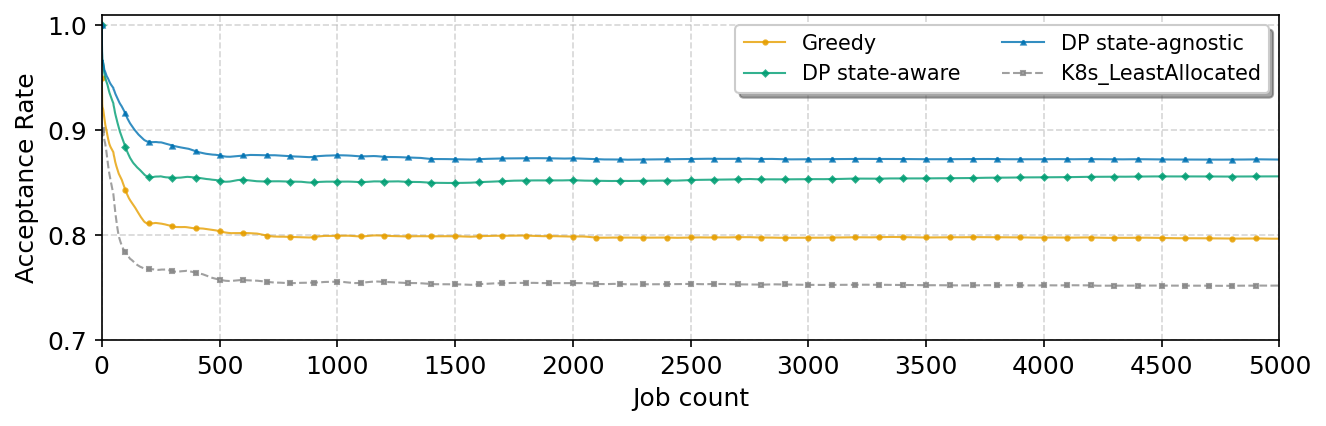

K4.0 Greedy :  4002.2038500000003
K4.0 Dynamic byState :  4272.5952
K4.0 Dynamic ALL :  4375.59465
K8s_leastAllocated :  3776.9532500000005


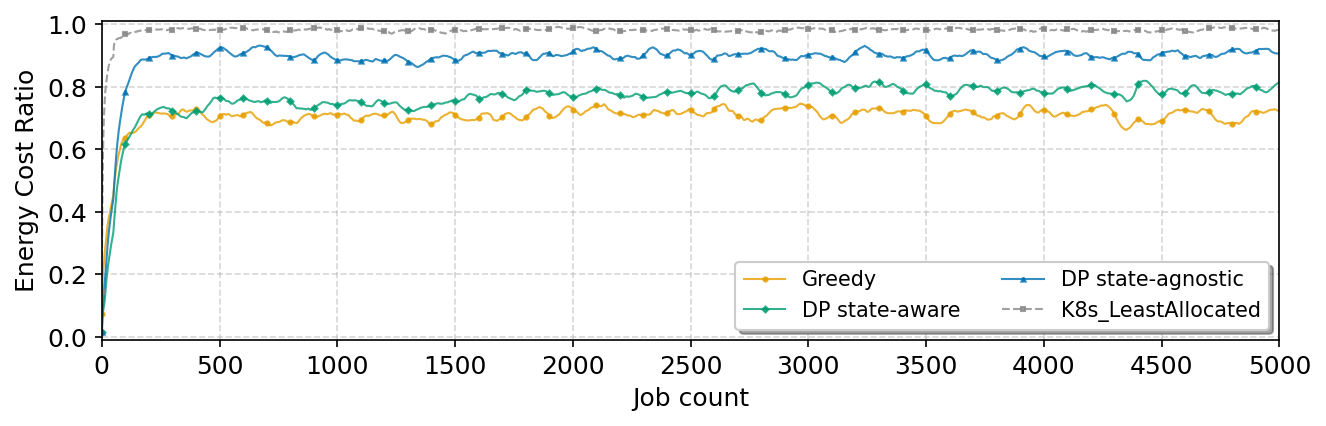

K4.0 Greedy :  3534.64765
K4.0 Dynamic byState :  3835.7005
K4.0 Dynamic ALL :  4480.1713500000005
K8s_leastAllocated :  4906.5028999999995


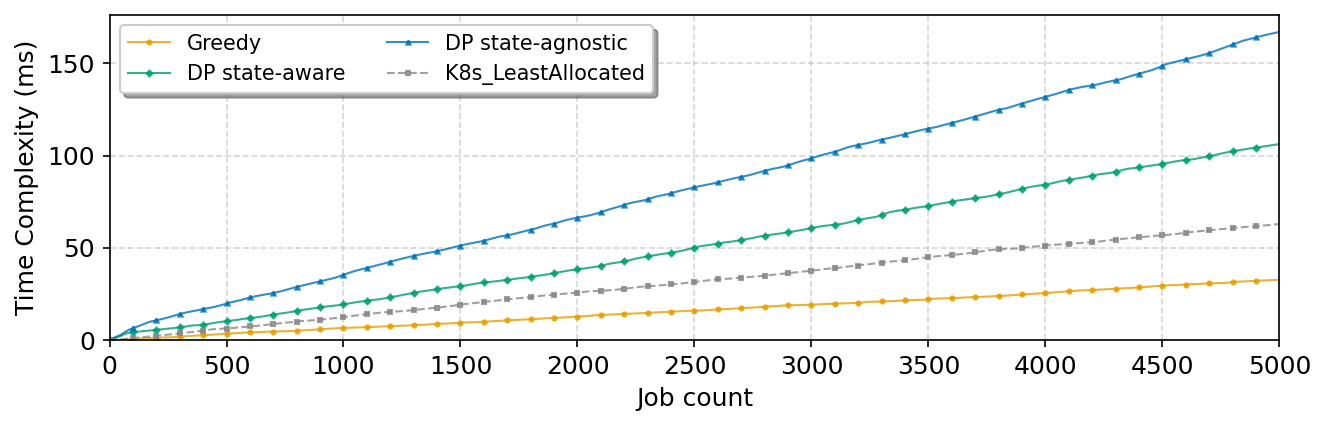

K4.0 Greedy :  80913.560155
K4.0 Dynamic byState :  259607.92450679996
K4.0 Dynamic ALL :  420807.5264502
K8s_leastAllocated :  159996.50193959998
['Greedy', 'DP\nstate-aware', 'DP\nstate-agnostic', 'K8s_\nRequestedTo\nCapacityRatio']


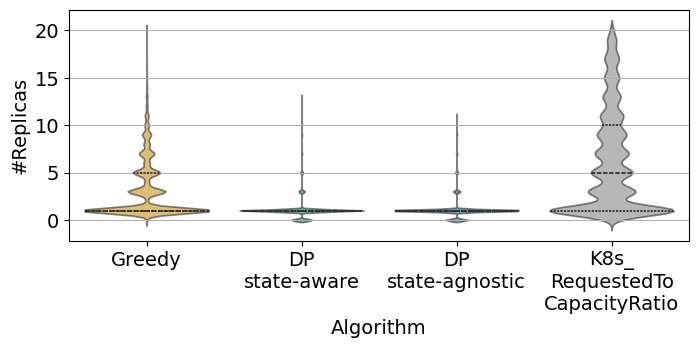

In [125]:
results_dict = plot_aggregated(algoName, all_dataframes, results_dict)
results_dict = plot_replicas(algoName, results_dict)

## >  Most Allocated

In [126]:
algoName = testNames[algo_i]
algo_i+=1

### > > Plot

In [127]:
all_dataframes = plot_AllDataFrames(algoName)

### > > Plot Aggregated

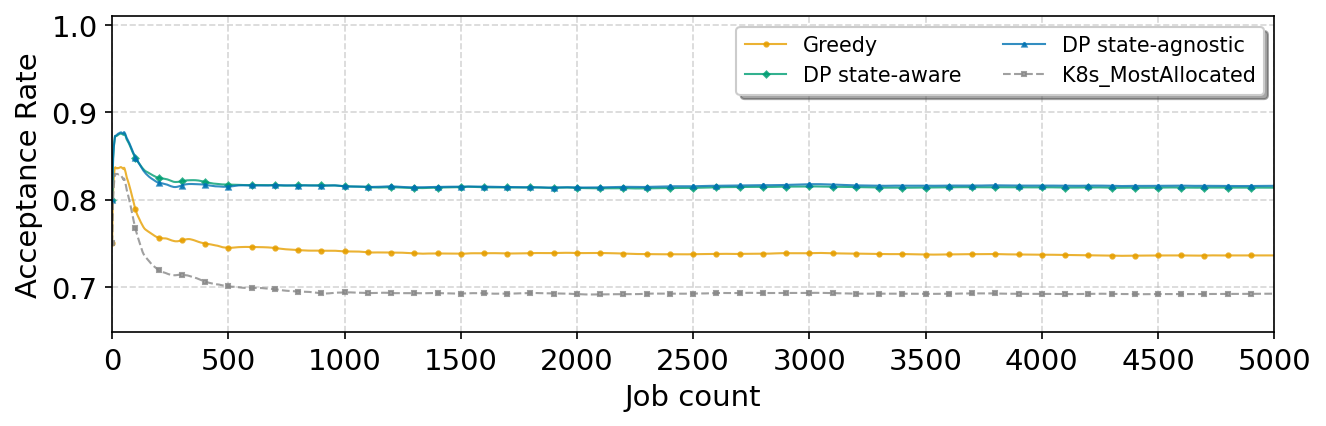

K4.0 Greedy :  3703.8261
K4.0 Dynamic byState :  4078.52465
K4.0 Dynamic ALL :  4083.3646
K8s_mostAllocated :  3480.98625


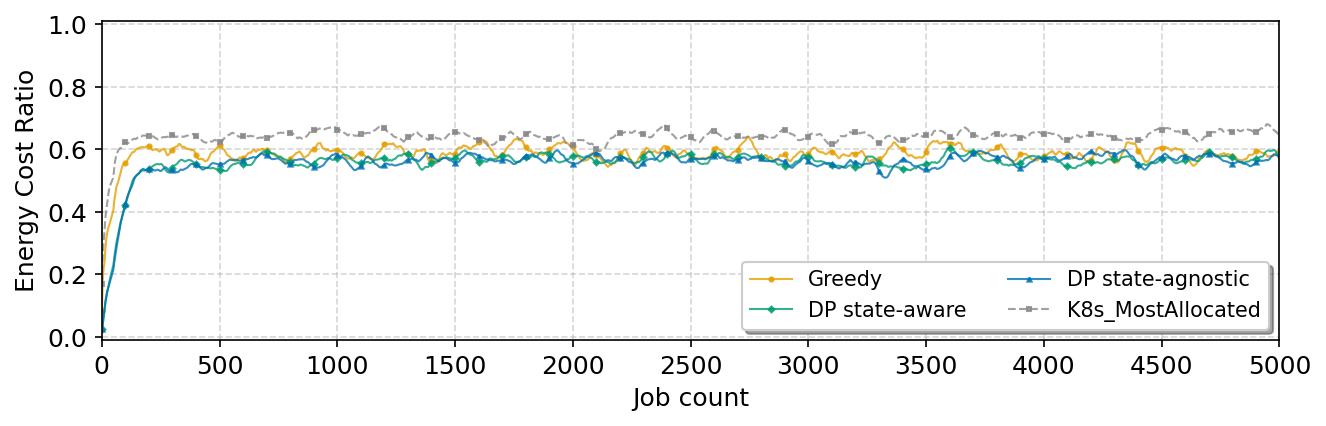

K4.0 Greedy :  2935.22725
K4.0 Dynamic byState :  2799.2812
K4.0 Dynamic ALL :  2794.0610500000003
K8s_mostAllocated :  3209.6266


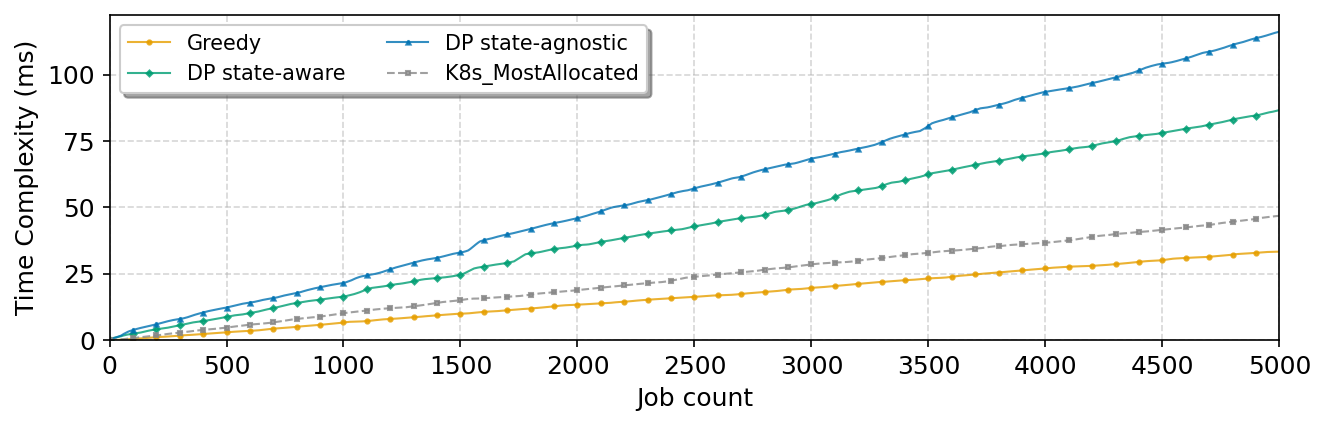

K4.0 Greedy :  83533.413065
K4.0 Dynamic byState :  220003.2634056
K4.0 Dynamic ALL :  291033.9700496
K8s_mostAllocated :  118618.33891620001


In [ ]:
results_dict = plot_aggregated(algoName, all_dataframes, results_dict)
results_dict = plot_replicas(algoName, results_dict)

## >  Requested To Capacity Ratio

In [ ]:
algoName = testNames[algo_i]
algo_i+=1

### > > Plot

In [ ]:
all_dataframes = plot_AllDataFrames(algoName)

### > > Plot Aggregated

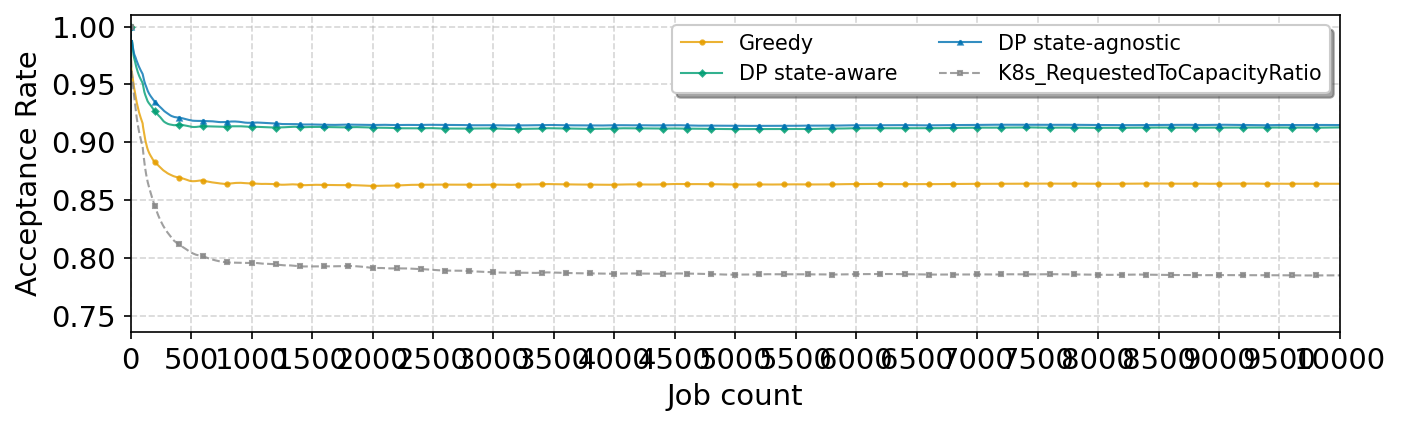

K4.0 Greedy :  8647.284950000001
K4.0 Dynamic byState :  9129.7648
K4.0 Dynamic ALL :  9158.745649999999
K8s_requestedToCapacityRatio :  7901.125499999999


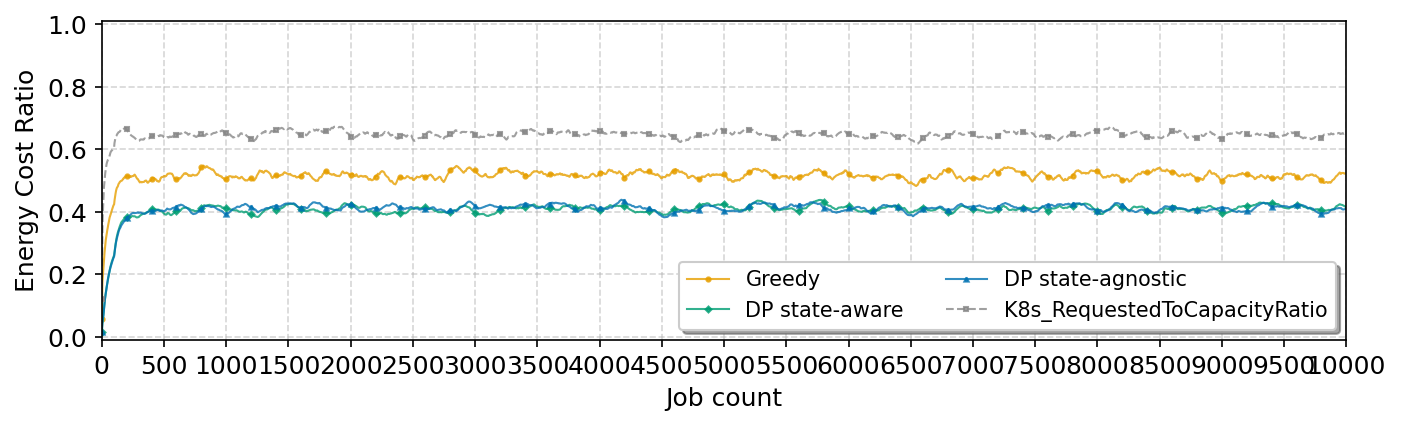

K4.0 Greedy :  5161.1179999999995
K4.0 Dynamic byState :  4080.35025
K4.0 Dynamic ALL :  4106.3277
K8s_requestedToCapacityRatio :  6474.1762


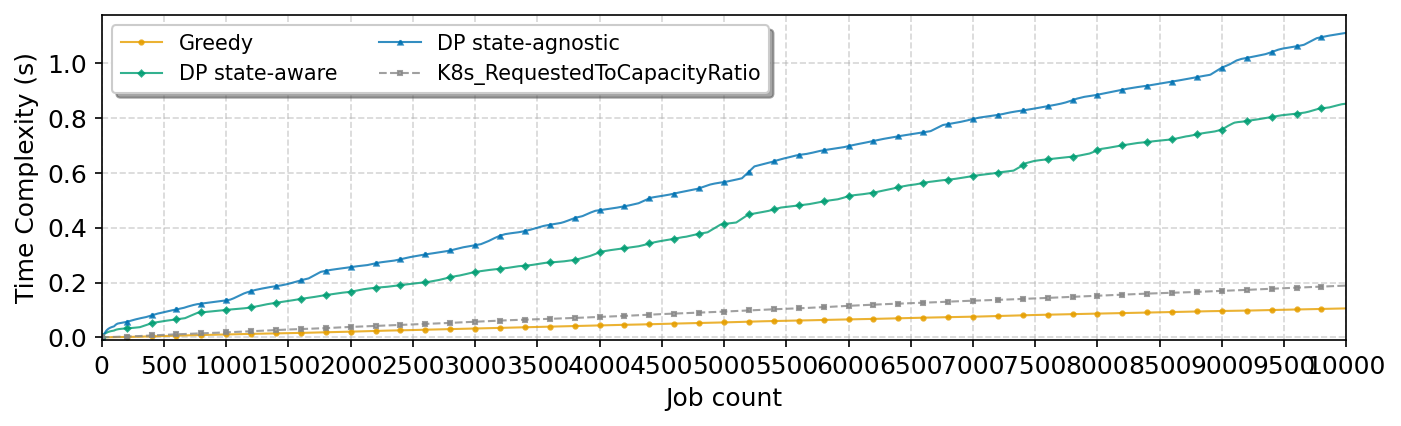

K4.0 Greedy :  544.035631457
K4.0 Dynamic byState :  4242.5882688892
K4.0 Dynamic ALL :  5761.4582977038
K8s_requestedToCapacityRatio :  955.2475776438
['Greedy', 'DP\nstate-aware', 'DP\nstate-agnostic', 'K8s_\nRequestedTo\nCapacityRatio']


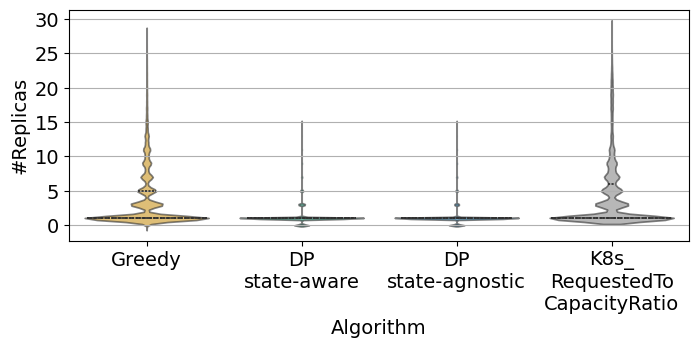

In [ ]:
results_dict = plot_aggregated(algoName, all_dataframes, results_dict)
results_dict = plot_replicas(algoName, results_dict)

# Multi Aware - 5 3 2 1 1

## >  Least Allocated

In [ ]:
algoName = testNames[algo_i]
algo_i+=1

### > > Plot

In [ ]:
all_dataframes = plot_AllDataFrames(algoName)

### > > Plot Aggregated

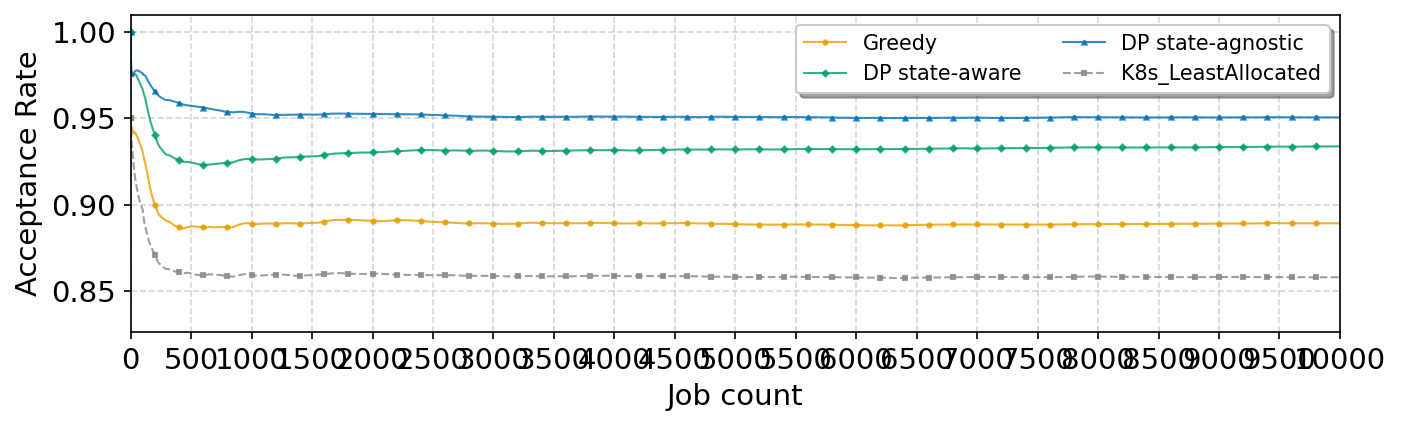

K4.0 Greedy :  8894.2201
K4.0 Dynamic byState :  9317.8249
K4.0 Dynamic ALL :  9517.68295
K8s_leastAllocated :  8589.33175


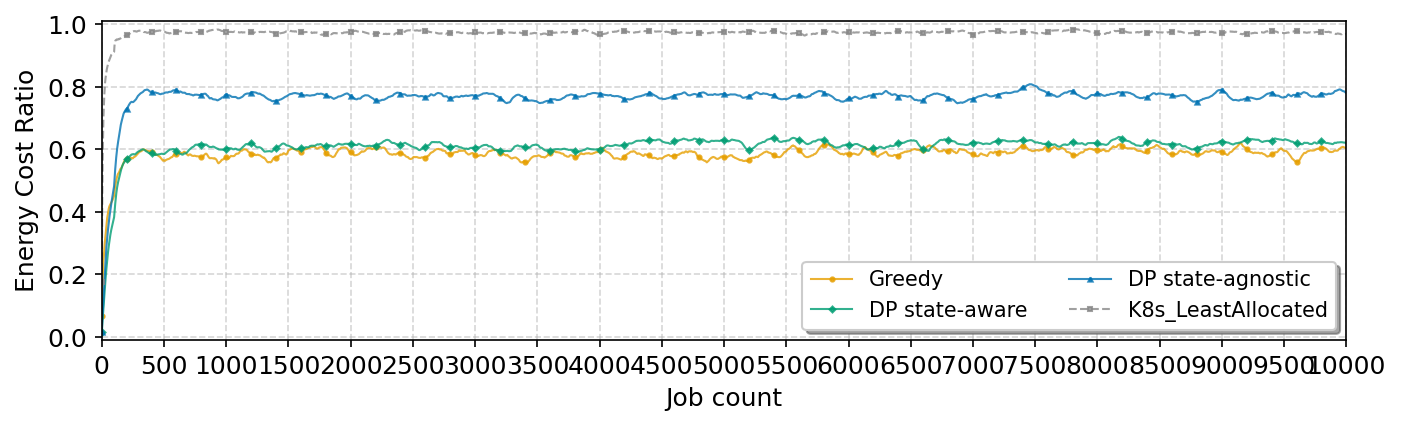

K4.0 Greedy :  5868.3751
K4.0 Dynamic byState :  6120.65105
K4.0 Dynamic ALL :  7682.35765
K8s_leastAllocated :  9735.4774


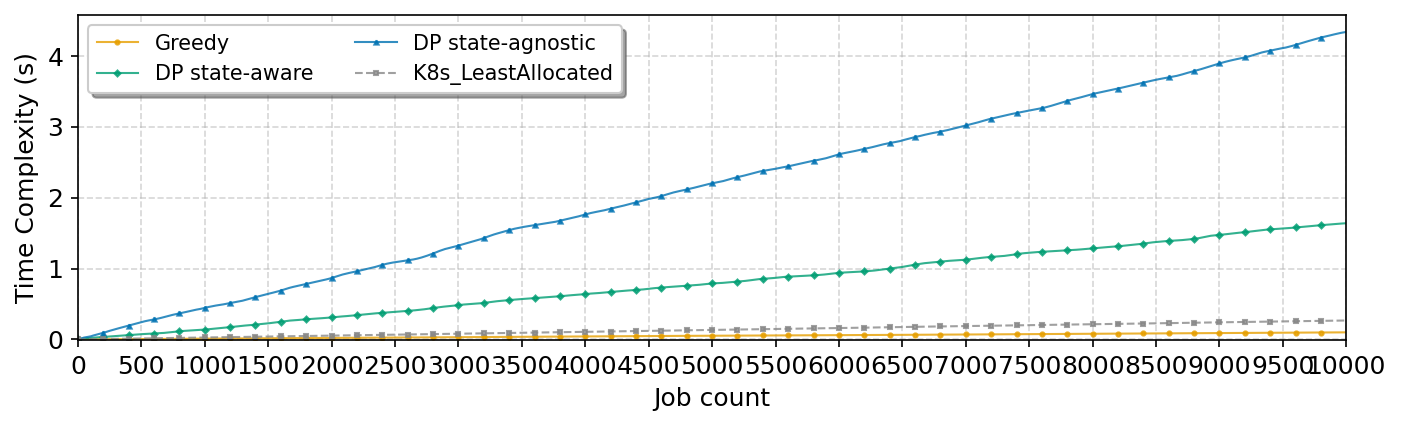

K4.0 Greedy :  506.06461502660005
K4.0 Dynamic byState :  8094.9165325686
K4.0 Dynamic ALL :  21971.146849717
K8s_leastAllocated :  1343.9737428262001
['Greedy', 'DP\nstate-aware', 'DP\nstate-agnostic', 'K8s_\nRequestedTo\nCapacityRatio']


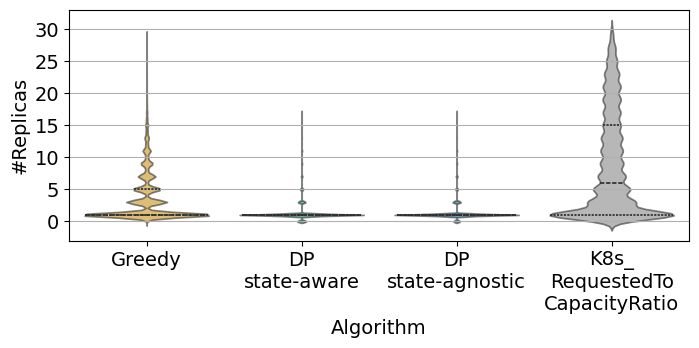

In [ ]:
results_dict = plot_aggregated(algoName, all_dataframes, results_dict)
results_dict = plot_replicas(algoName, results_dict)

## >  Most Allocated

In [ ]:
algoName = testNames[algo_i]
algo_i+=1

### > > Plot

In [ ]:
all_dataframes = plot_AllDataFrames(algoName)

### > > Plot Aggregated

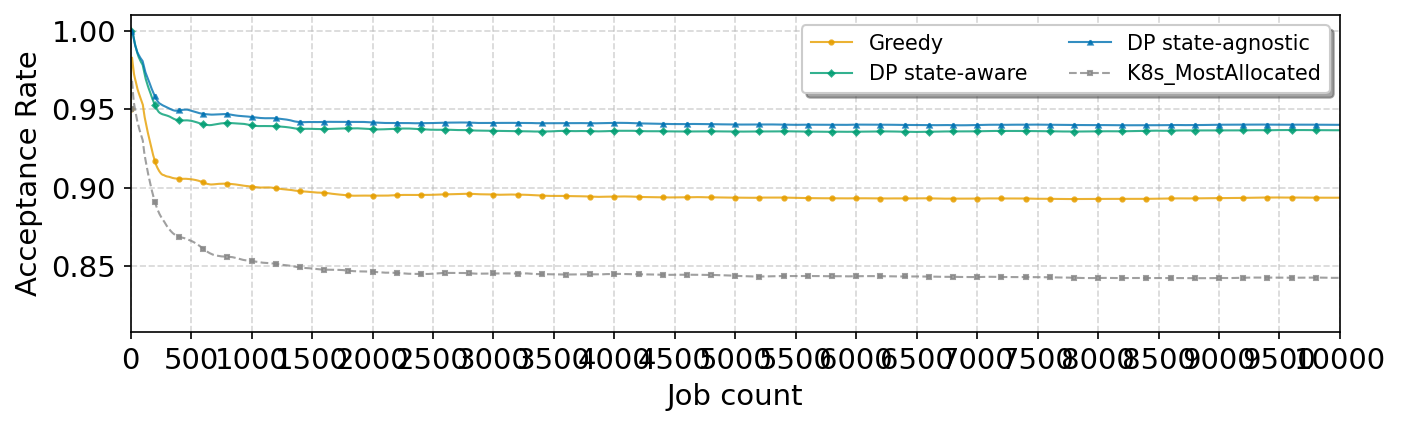

K4.0 Greedy :  8957.49265
K4.0 Dynamic byState :  9373.598
K4.0 Dynamic ALL :  9417.551749999999
K8s_mostAllocated :  8469.958999999999


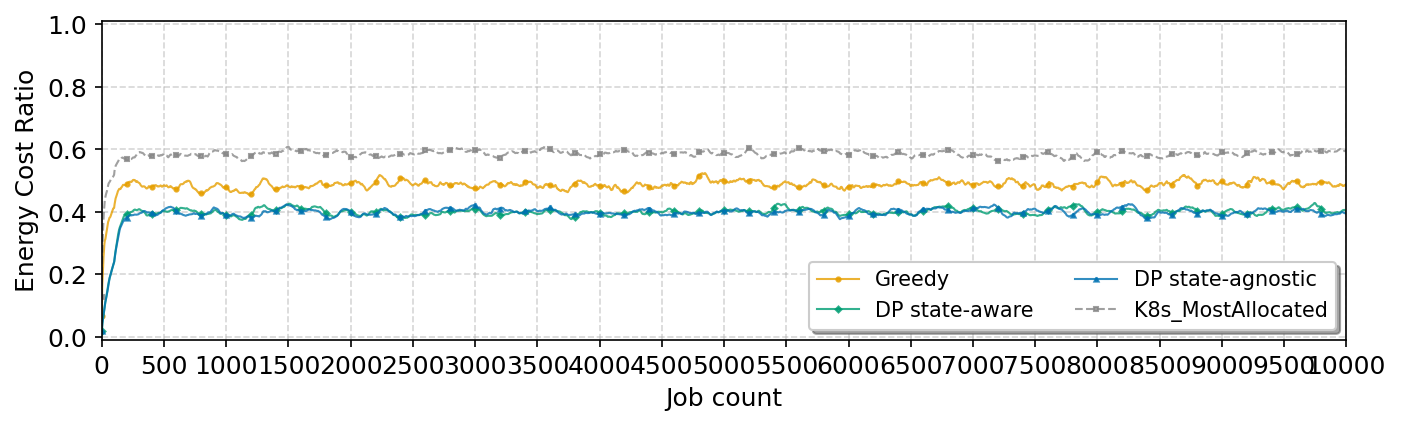

K4.0 Greedy :  4870.78655
K4.0 Dynamic byState :  3991.6101
K4.0 Dynamic ALL :  3977.8452500000003
K8s_mostAllocated :  5849.3989


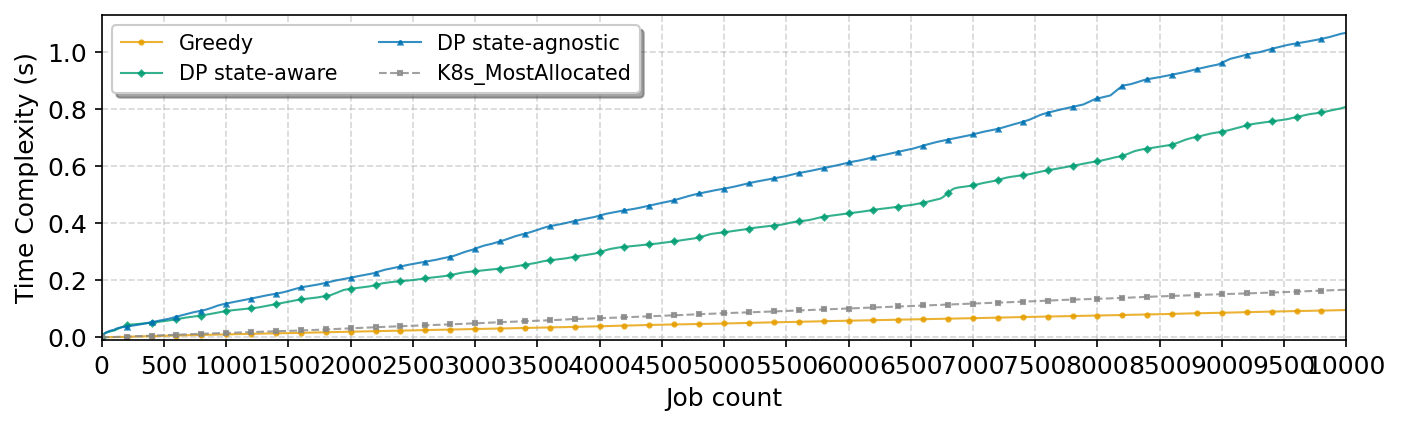

K4.0 Greedy :  484.0291275206
K4.0 Dynamic byState :  3904.8041965626003
K4.0 Dynamic ALL :  5312.6566233134
K8s_mostAllocated :  842.0124724448
['Greedy', 'DP\nstate-aware', 'DP\nstate-agnostic', 'K8s_\nRequestedTo\nCapacityRatio']


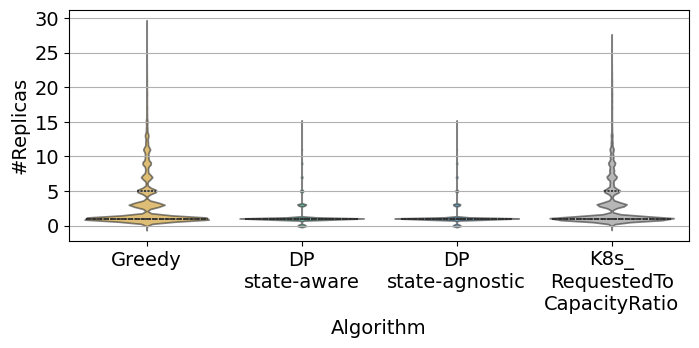

In [ ]:
results_dict = plot_aggregated(algoName, all_dataframes, results_dict)
results_dict = plot_replicas(algoName, results_dict)

## >  Requested To Capacity Ratio

In [ ]:
algoName = testNames[algo_i]
algo_i+=1

### > > Plot

In [ ]:
all_dataframes = plot_AllDataFrames(algoName)

### > > Plot Aggregated

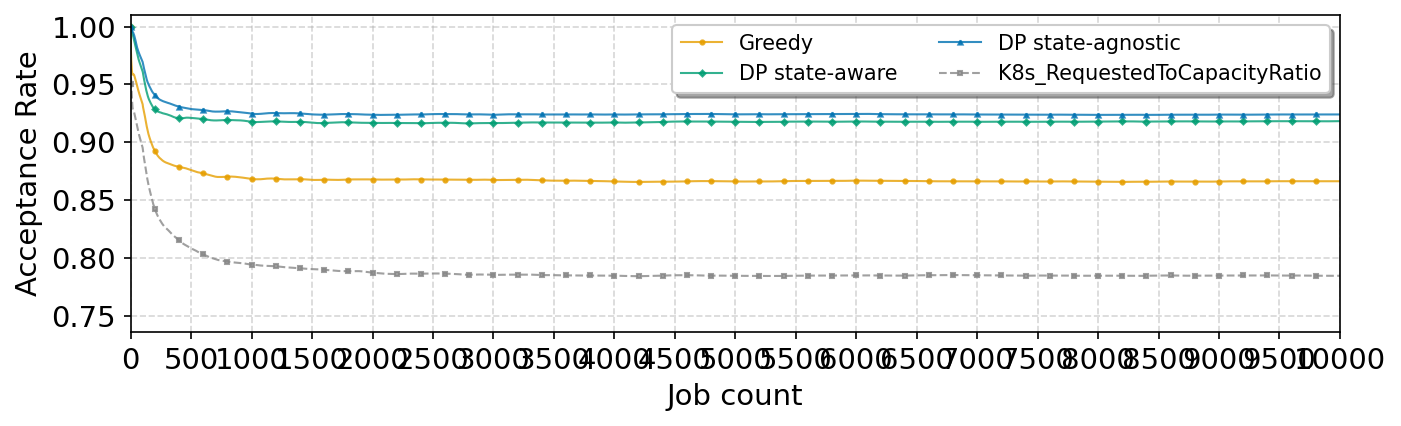

K4.0 Greedy :  8681.5265
K4.0 Dynamic byState :  9183.20275
K4.0 Dynamic ALL :  9250.811450000001
K8s_requestedToCapacityRatio :  7888.14755


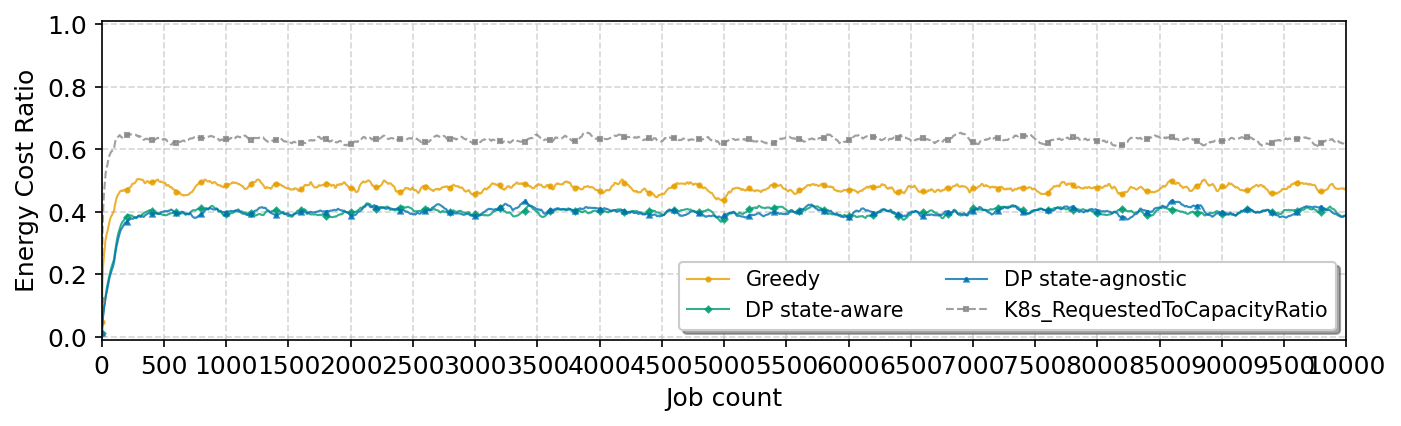

K4.0 Greedy :  4771.140600000001
K4.0 Dynamic byState :  3991.00515
K4.0 Dynamic ALL :  3993.1164500000004
K8s_requestedToCapacityRatio :  6313.9424


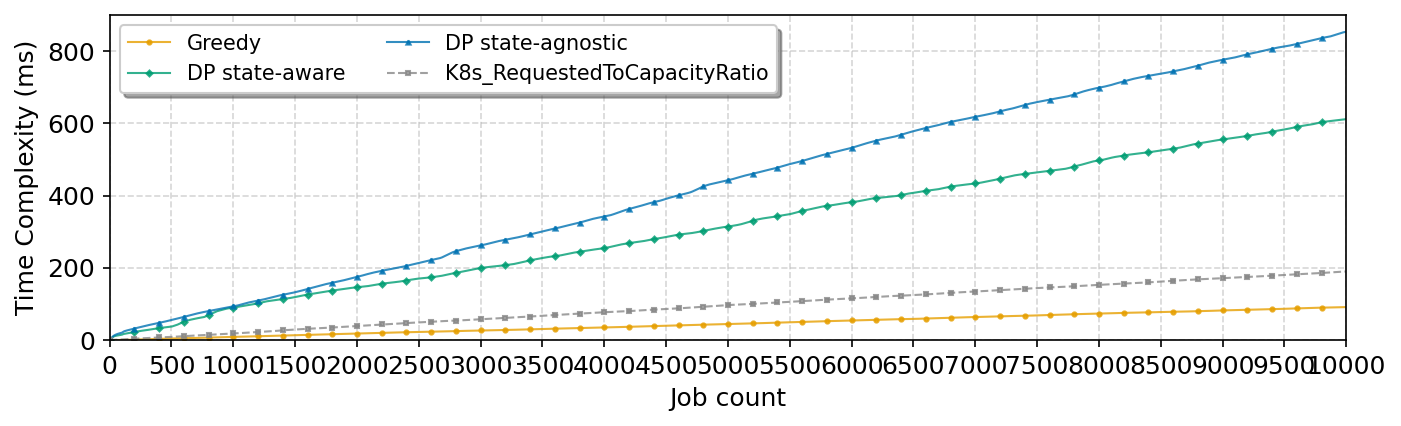

K4.0 Greedy :  455685.54493880004
K4.0 Dynamic byState :  3207235.3972676005
K4.0 Dynamic ALL :  4413204.4734934
K8s_requestedToCapacityRatio :  966538.6697924
['Greedy', 'DP\nstate-aware', 'DP\nstate-agnostic', 'K8s_\nRequestedTo\nCapacityRatio']


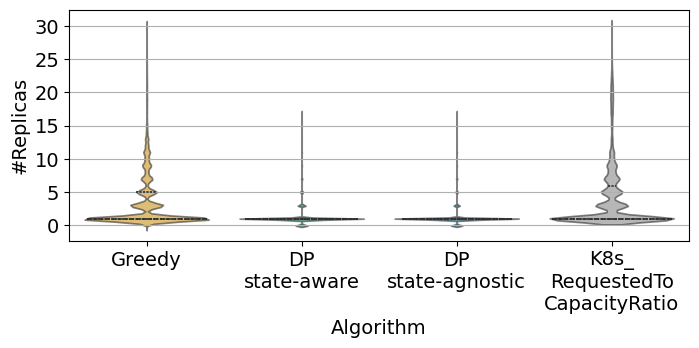

In [ ]:
results_dict = plot_aggregated(algoName, all_dataframes, results_dict)
results_dict = plot_replicas(algoName, results_dict)

# Multi Aware - 3 2 1 1 1

## >  Least Allocated

In [ ]:
algoName = testNames[algo_i]
algo_i+=1

### > > Plot

In [ ]:
all_dataframes = plot_AllDataFrames(algoName)

### > > Plot Aggregated

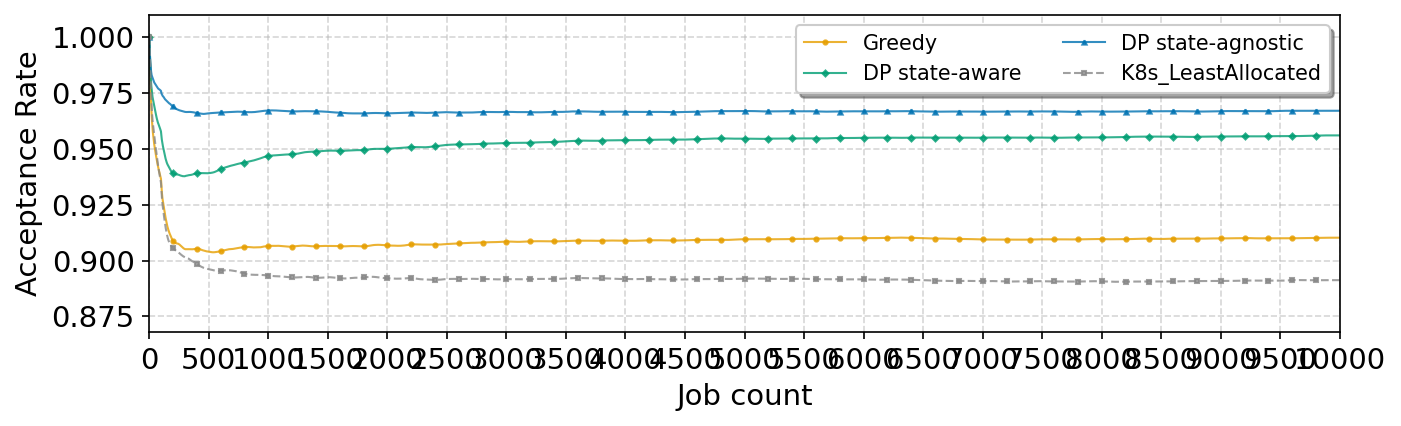

K4.0 Greedy :  9090.0926
K4.0 Dynamic byState :  9527.86865
K4.0 Dynamic ALL :  9668.2032
K8s_leastAllocated :  8924.2449


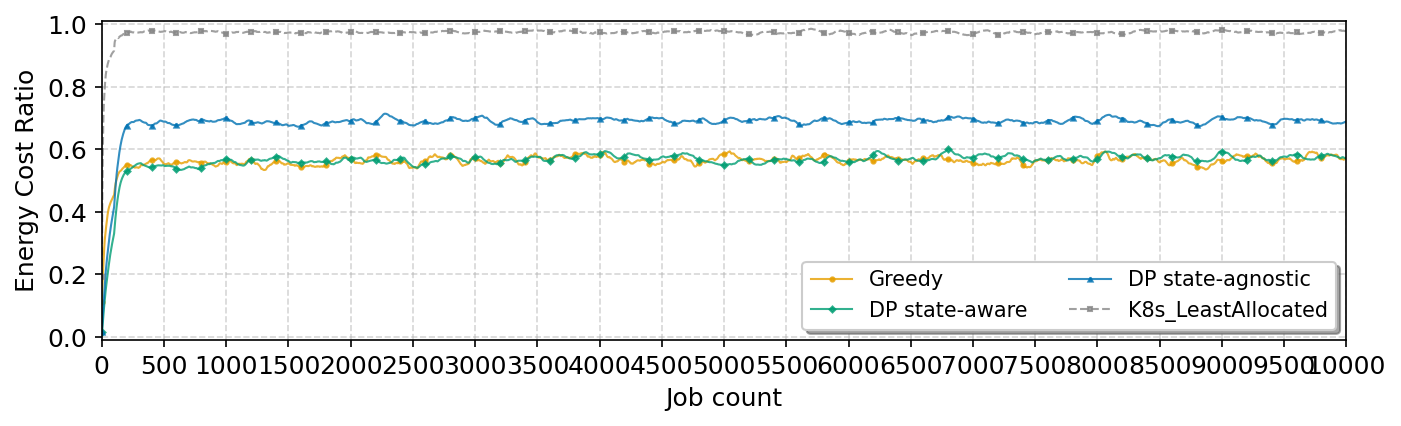

K4.0 Greedy :  5636.8759
K4.0 Dynamic byState :  5657.4477
K4.0 Dynamic ALL :  6879.45875
K8s_leastAllocated :  9740.77795


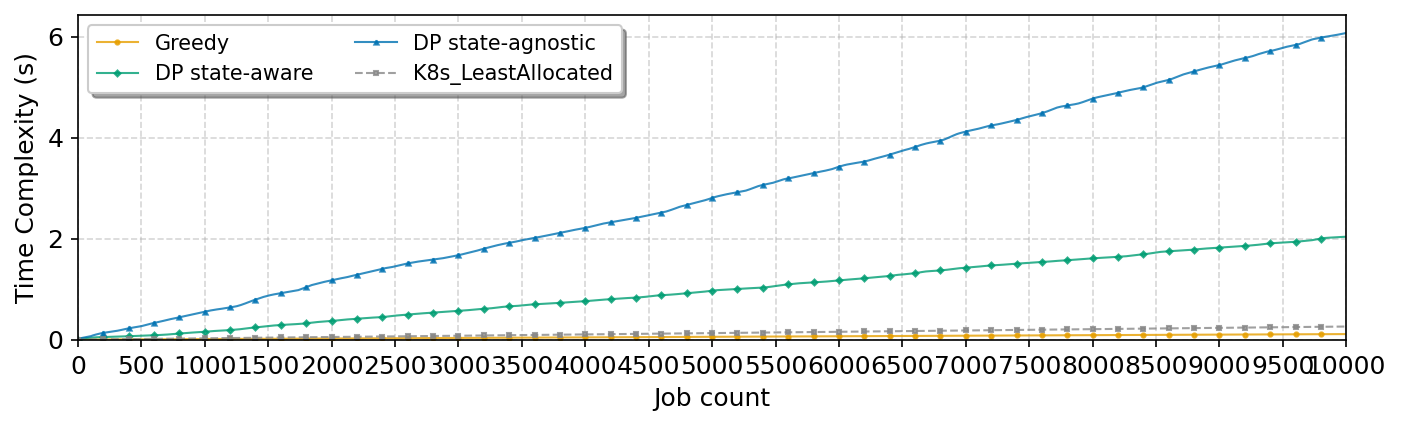

K4.0 Greedy :  545.2248375366
K4.0 Dynamic byState :  9968.0875979636
K4.0 Dynamic ALL :  29483.8760400128
K8s_leastAllocated :  1299.8924861991998
['Greedy', 'DP\nstate-aware', 'DP\nstate-agnostic', 'K8s_\nRequestedTo\nCapacityRatio']


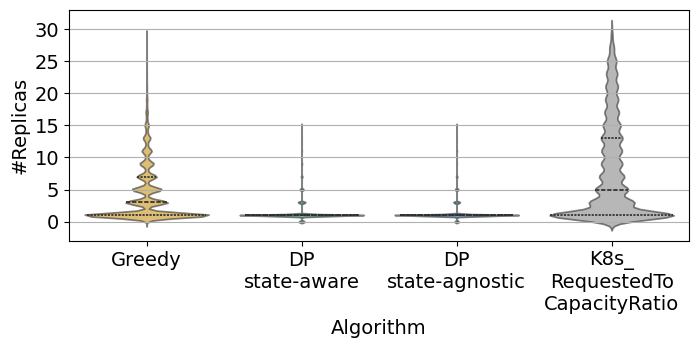

In [ ]:
results_dict = plot_aggregated(algoName, all_dataframes, results_dict)
results_dict = plot_replicas(algoName, results_dict)

## >  Most Allocated

In [ ]:
algoName = testNames[algo_i]
algo_i+=1

### > > Plot

In [ ]:
all_dataframes = plot_AllDataFrames(algoName)

### > > Plot Aggregated

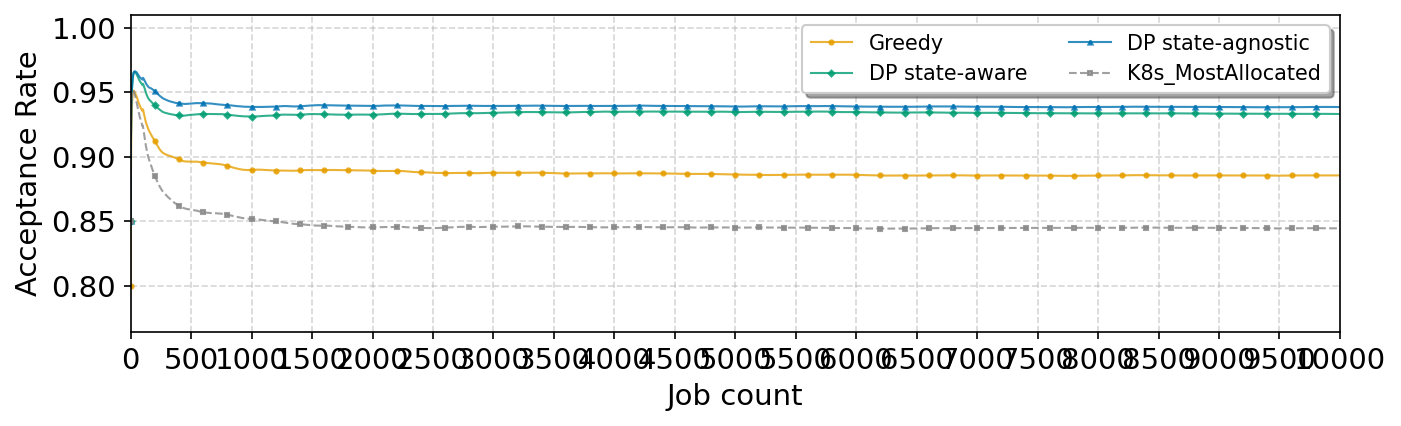

K4.0 Greedy :  8881.00595
K4.0 Dynamic byState :  9341.6963
K4.0 Dynamic ALL :  9396.010300000002
K8s_mostAllocated :  8475.4301


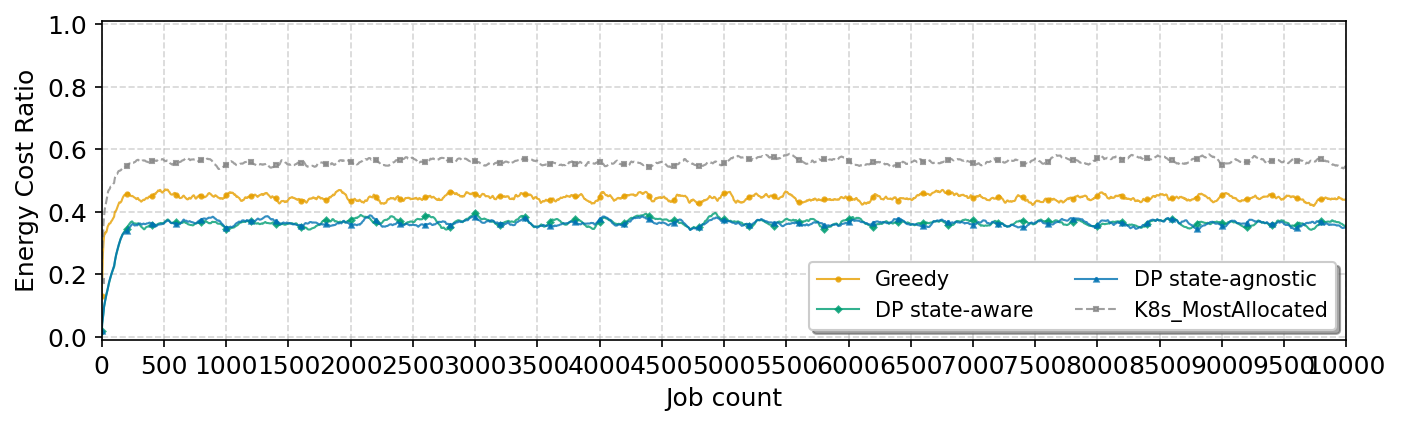

K4.0 Greedy :  4449.0251499999995
K4.0 Dynamic byState :  3643.48715
K4.0 Dynamic ALL :  3629.6804
K8s_mostAllocated :  5602.3981


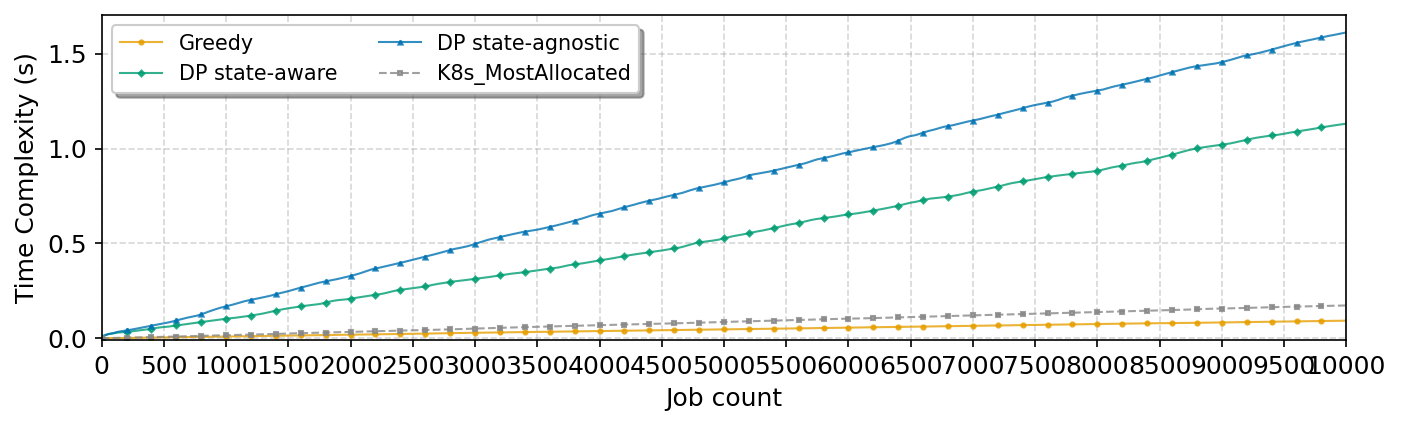

K4.0 Greedy :  468.5455640184
K4.0 Dynamic byState :  5529.194775927999
K4.0 Dynamic ALL :  8258.4134769526
K8s_mostAllocated :  864.7128697932
['Greedy', 'DP\nstate-aware', 'DP\nstate-agnostic', 'K8s_\nRequestedTo\nCapacityRatio']


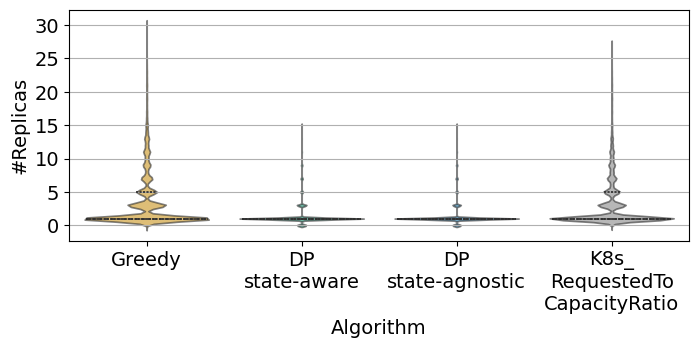

In [ ]:
results_dict = plot_aggregated(algoName, all_dataframes, results_dict)
results_dict = plot_replicas(algoName, results_dict)

## >  Requested To Capacity Ratio

In [ ]:
algoName = testNames[algo_i]
algo_i+=1

### > > Plot

In [ ]:
all_dataframes = plot_AllDataFrames(algoName)

### > > Plot Aggregated

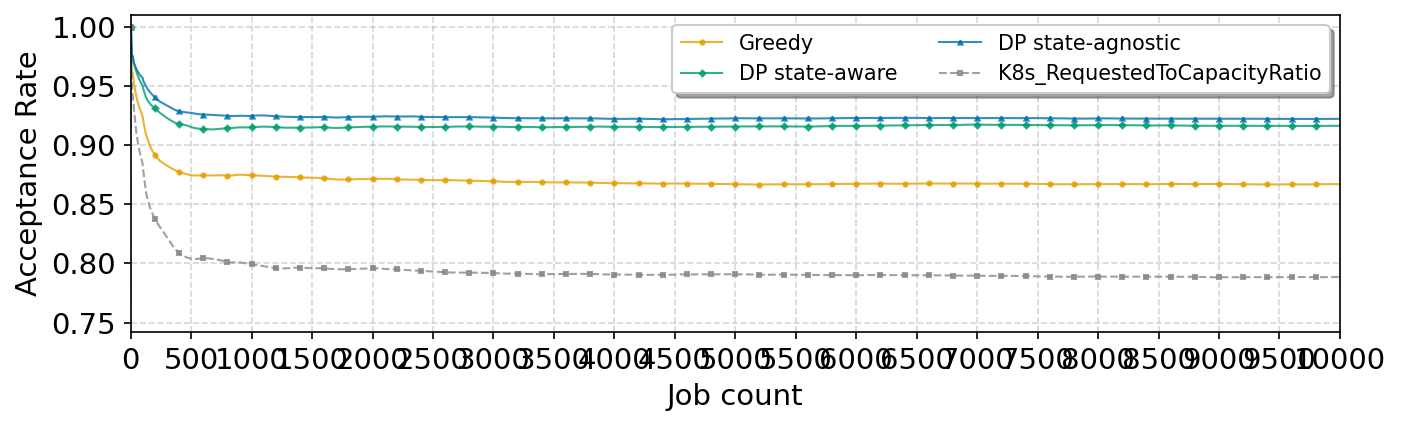

K4.0 Greedy :  8696.7998
K4.0 Dynamic byState :  9165.24225
K4.0 Dynamic ALL :  9237.03515
K8s_requestedToCapacityRatio :  7934.2990500000005


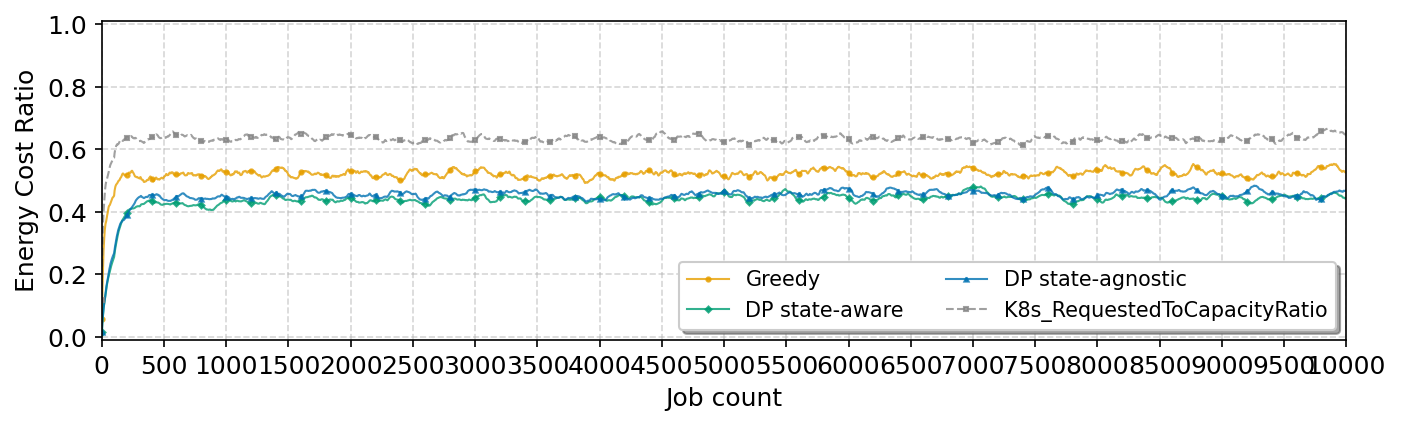

K4.0 Greedy :  5215.3745
K4.0 Dynamic byState :  4400.246050000001
K4.0 Dynamic ALL :  4532.786
K8s_requestedToCapacityRatio :  6338.54245


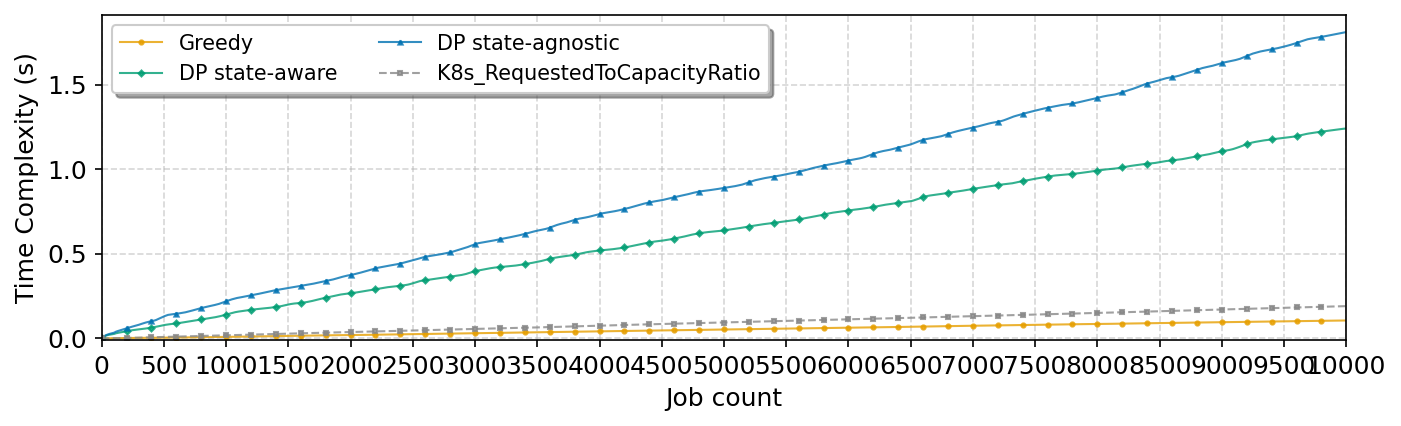

K4.0 Greedy :  530.760985437
K4.0 Dynamic byState :  6386.756087432601
K4.0 Dynamic ALL :  9137.5723627152
K8s_requestedToCapacityRatio :  950.3257097162
['Greedy', 'DP\nstate-aware', 'DP\nstate-agnostic', 'K8s_\nRequestedTo\nCapacityRatio']


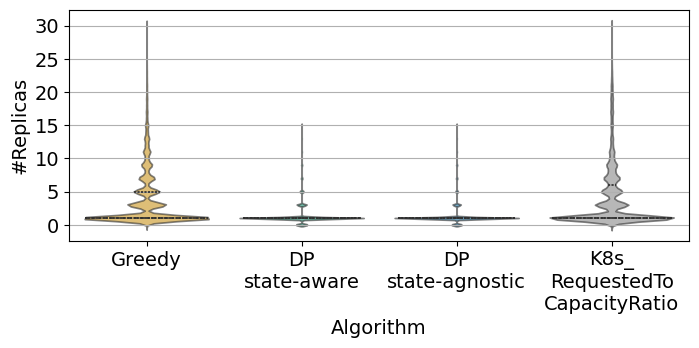

In [ ]:
results_dict = plot_aggregated(algoName, all_dataframes, results_dict)
results_dict = plot_replicas(algoName, results_dict)

# Multi Aware - 3 2 2 1 1

## >  Least Allocated

In [ ]:
algoName = testNames[algo_i]
algo_i+=1

### > > Plot

In [ ]:
all_dataframes = plot_AllDataFrames(algoName)

### > > Plot Aggregated

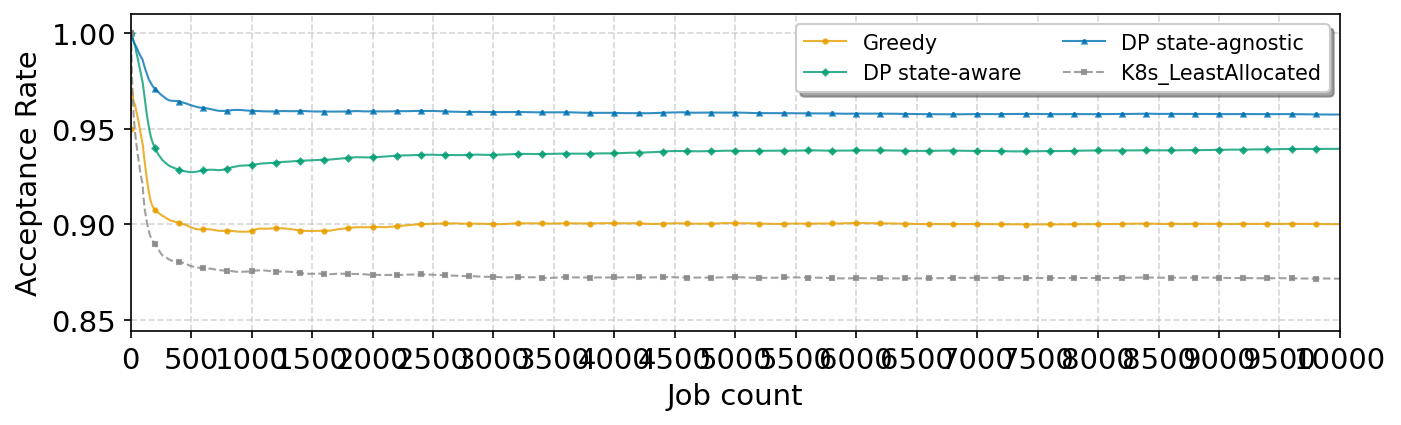

K4.0 Greedy :  9002.07705
K4.0 Dynamic byState :  9372.469799999999
K4.0 Dynamic ALL :  9588.0641
K8s_leastAllocated :  8733.6291


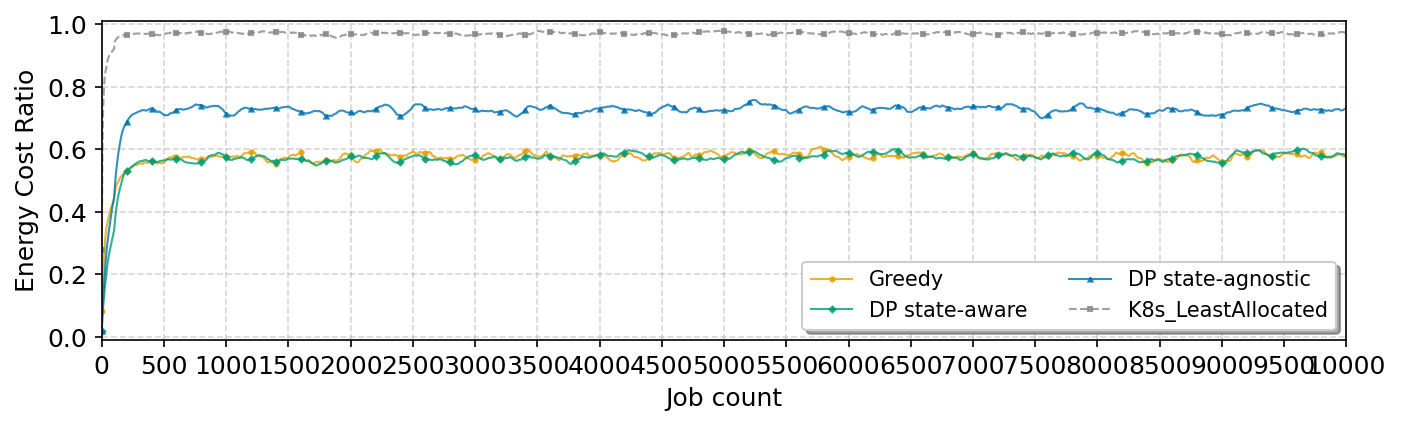

K4.0 Greedy :  5760.44485
K4.0 Dynamic byState :  5721.380450000001
K4.0 Dynamic ALL :  7238.290599999999
K8s_leastAllocated :  9701.9316


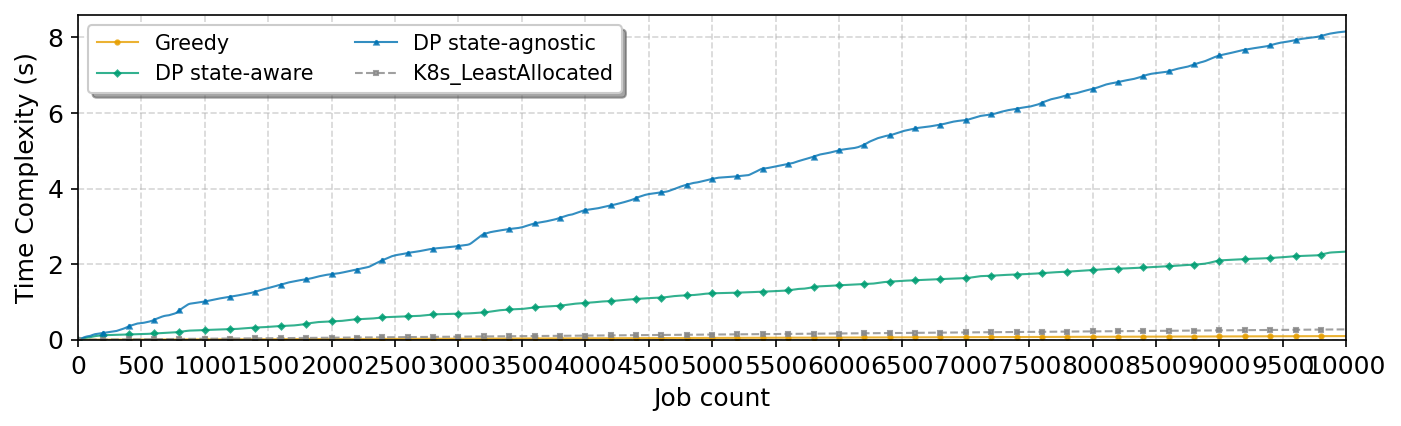

K4.0 Greedy :  478.21625157079995
K4.0 Dynamic byState :  11868.3527481714
K4.0 Dynamic ALL :  42382.050330796
K8s_leastAllocated :  1380.2381034378
['Greedy', 'DP\nstate-aware', 'DP\nstate-agnostic', 'K8s_\nRequestedTo\nCapacityRatio']


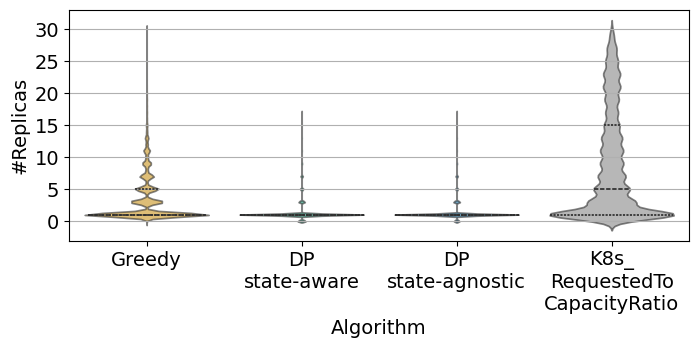

In [ ]:
results_dict = plot_aggregated(algoName, all_dataframes, results_dict)
results_dict = plot_replicas(algoName, results_dict)

## >  Most Allocated

In [ ]:
algoName = testNames[algo_i]
algo_i+=1

### > > Plot

In [ ]:
all_dataframes = plot_AllDataFrames(algoName)

### > > Plot Aggregated

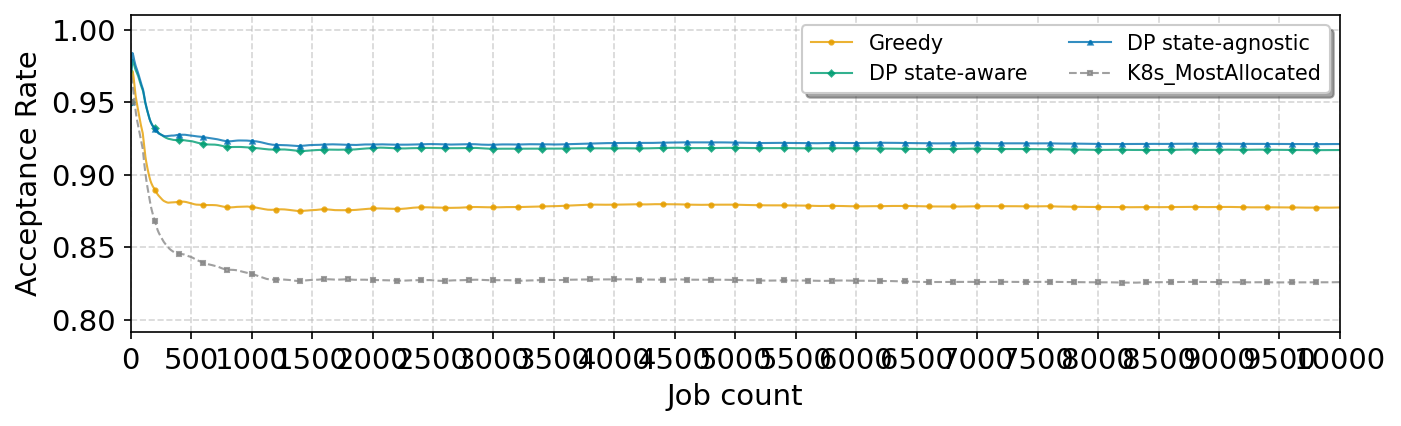

K4.0 Greedy :  8785.60245
K4.0 Dynamic byState :  9185.1283
K4.0 Dynamic ALL :  9220.8159
K8s_mostAllocated :  8290.578


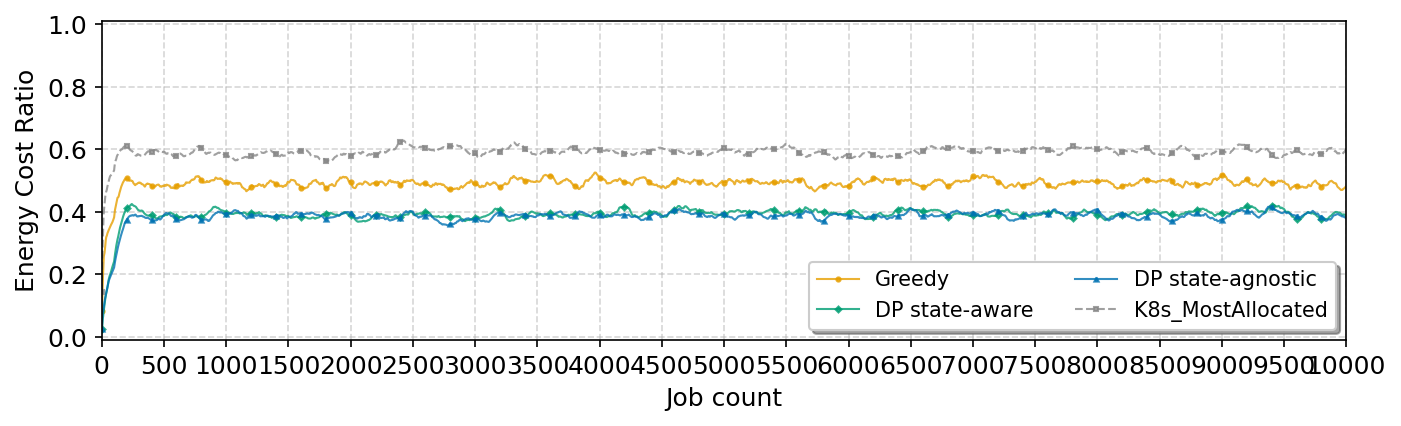

K4.0 Greedy :  4918.85845
K4.0 Dynamic byState :  3924.33745
K4.0 Dynamic ALL :  3862.87635
K8s_mostAllocated :  5920.450400000001


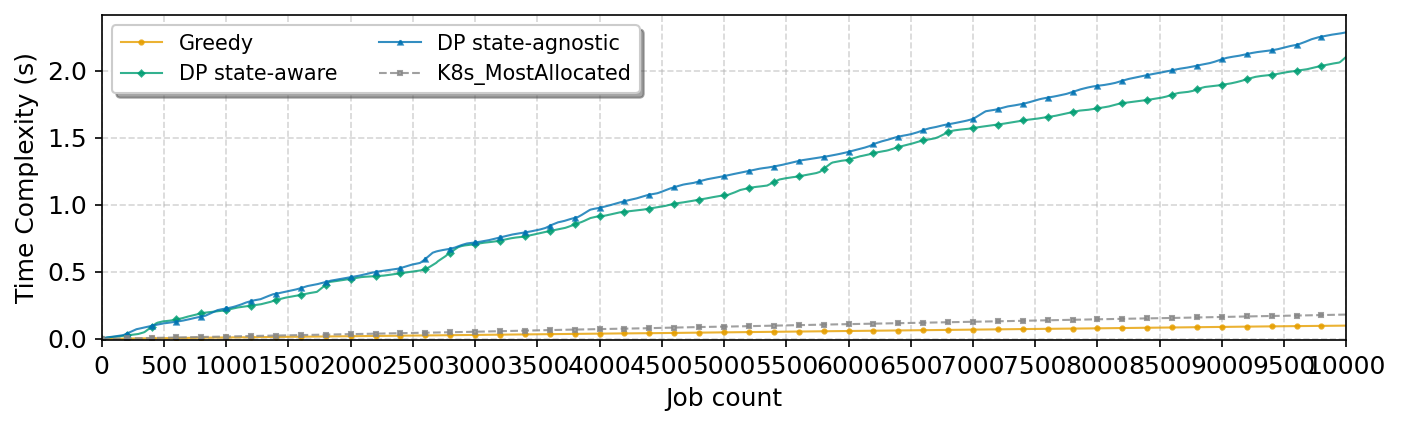

K4.0 Greedy :  487.25960632240003
K4.0 Dynamic byState :  10947.9409993276
K4.0 Dynamic ALL :  11858.7400085402
K8s_mostAllocated :  908.9071832486
['Greedy', 'DP\nstate-aware', 'DP\nstate-agnostic', 'K8s_\nRequestedTo\nCapacityRatio']


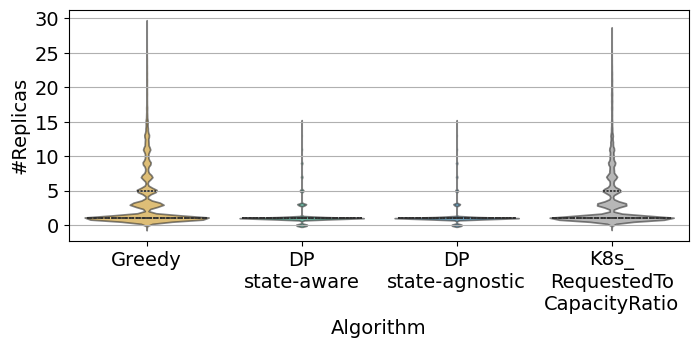

In [ ]:
results_dict = plot_aggregated(algoName, all_dataframes, results_dict)
results_dict = plot_replicas(algoName, results_dict)

## >  Requested To Capacity Ratio

In [ ]:
algoName = testNames[algo_i]
algo_i+=1

### > > Plot

In [ ]:
all_dataframes = plot_AllDataFrames(algoName)

### > > Plot Aggregated

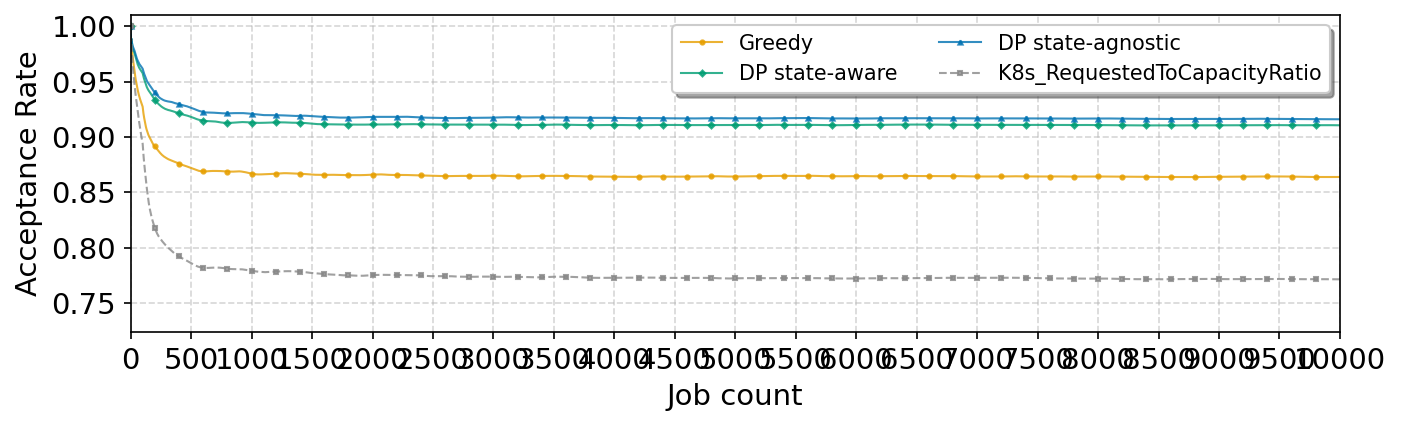

K4.0 Greedy :  8661.134250000001
K4.0 Dynamic byState :  9120.90635
K4.0 Dynamic ALL :  9183.08825
K8s_requestedToCapacityRatio :  7759.124249999999


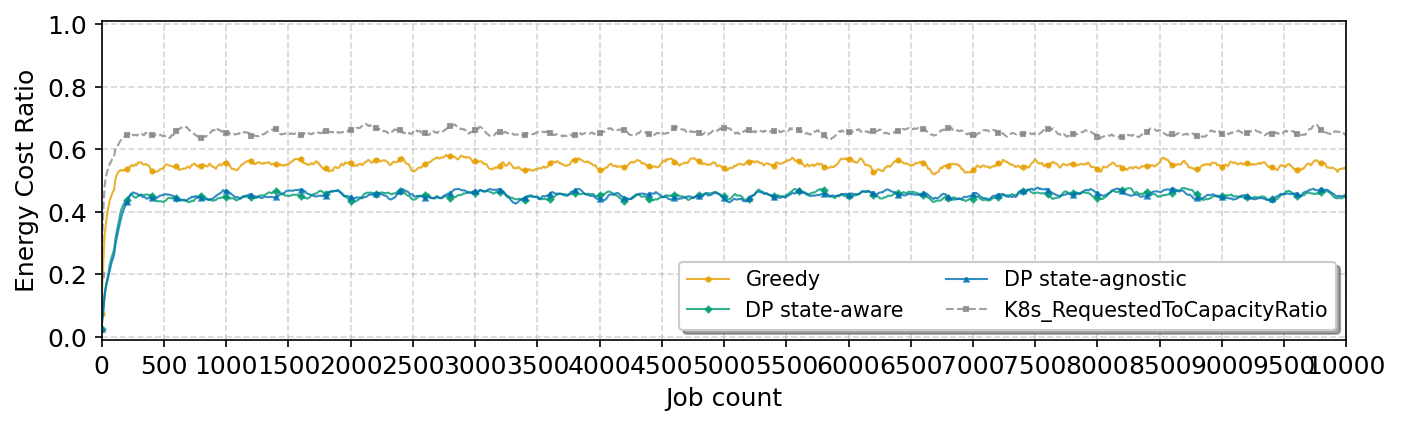

K4.0 Greedy :  5500.388650000001
K4.0 Dynamic byState :  4507.02215
K4.0 Dynamic ALL :  4522.8682
K8s_requestedToCapacityRatio :  6532.33375


KeyboardInterrupt: 

In [ ]:
results_dict = plot_aggregated(algoName, all_dataframes, results_dict)
results_dict = plot_replicas(algoName, results_dict)

# The end


In [ ]:
# k8sMap = {
#     "l": "LA",
#     "m": "MA",
#     "r": "RCR"
# }

# cost_map = {
#   "4,2,2,1,1" : "W1",
#   "5,3,2,2,1" : "W2",
#   "3,2,1,1,1" : "W3",
#   "3,2,2,1,1" : "W4",
# }

# row = ""
# iter = 0
# for k,v in results_dict.items():

#   if iter%24==0:
#     k_split = k.split(":")

#     entry_name="$"
#     entry_name += k8sMap[k_split[0][0]]
#     w = k_split[0].split("_")[-1].replace("-", ",")
#     entry_name += "_{"+cost_map[w]+"}$"

#     row = entry_name

#   if not "Time" in k:
#     if "mean" in k:
#       row += " & "+f"{round(v*100.,1)}"
#     elif "std" in k:
#       row += "$\\pm$"+f"{round(v*100.,1)}"
#     else:
#         print("WTF: ", k)
#     # print(v, "\t\t", round(v*100.,1), "%")

#   else:
#     if "mean" in k:
#       row += " & "+f"{round(v/1_000_000.,0)}"
#     elif "std" in k:
#       row += "$\\pm$"+f"{round(v/1_000_000.,0)}"
#     else:
#         print("WTF: ", k)
#     # print(v, "\t\t", round(v/1_000_000.,0), "ms")

#   if iter%24==23:
#     row+="\\\\"
#     print(row)
#   iter+=1

In [ ]:
k8sMap = {
    "l": "LA",
    "m": "MA",
    "r": "RCR"
}

cost_map = {
  "4,2,2,1,1" : "W1",
  "5,3,2,2,1" : "W2",
  "3,2,1,1,1" : "W3",
  "3,2,2,1,1" : "W4",
}

for metric in ["Acceptance", "Energy", "Time", "Replica"]:
  row = ""
  iter = 0
  print(metric)
  for k,v in results_dict.items():
    if metric not in k:
      continue

    if iter%8==0:
      k_split = k.split(":")

      entry_name="$"
      entry_name += k8sMap[k_split[0][0]]
      w = k_split[0].split("_")[-1].replace("-", ",")
      entry_name += "_{"+cost_map[w]+"}$"

      row = entry_name

    

    if "Time" in k:
      if "mean" in k:
        row += " & "+f"{int(round(v/1_000_000.,0))}"
      elif "std" in k:
        row += "$\\pm$"+f"{int(round(v/1_000_000.,0))}"
      else:
          print("WTF: ", k)
    
    elif "Replica" in k:
      if "mean" in k:
        row += " & "+f"{round(v,2)}"
      elif "std" in k:
        row += "$\\pm$"+f"{round(v, 2)}"
      else:
          print("WTF: ", k)
    
    else:
      if "mean" in k:
        row += " & "+f"{round(v*100.,1)}"
      elif "std" in k:
        row += "$\\pm$"+f"{round(v*100.,1)}"
      else:
          print("WTF: ", k)

    if iter%8==7:
      row+="\\\\"
      print(row)
    iter+=1

Acceptance
$LA_{W1}$ & 88.2$\pm$0.9 & 91.8$\pm$0.6 & 94.1$\pm$0.5 & 86.0$\pm$1.0\\
$MA_{W1}$ & 85.1$\pm$1.3 & 89.7$\pm$0.8 & 90.2$\pm$0.8 & 81.2$\pm$1.6\\
$RCR_{W1}$ & 81.3$\pm$1.2 & 86.9$\pm$0.8 & 87.5$\pm$0.8 & 75.2$\pm$1.7\\
$LA_{W2}$ & 86.7$\pm$0.7 & 91.7$\pm$0.6 & 93.3$\pm$0.6 & 84.4$\pm$1.0\\
$MA_{W2}$ & 85.5$\pm$1.0 & 90.7$\pm$0.5 & 90.9$\pm$0.6 & 80.7$\pm$1.6\\
$RCR_{W2}$ & 86.1$\pm$0.9 & 91.2$\pm$0.7 & 92.0$\pm$0.7 & 79.2$\pm$1.5\\
$LA_{W3}$ & 88.0$\pm$0.7 & 92.2$\pm$0.7 & 93.9$\pm$0.5 & 87.5$\pm$0.8\\
$MA_{W3}$ & 87.6$\pm$0.7 & 92.6$\pm$0.4 & 93.2$\pm$0.3 & 82.1$\pm$1.3\\
$RCR_{W3}$ & 83.9$\pm$0.8 & 91.3$\pm$0.3 & 91.7$\pm$0.3 & 76.5$\pm$1.5\\
$LA_{W4}$ & 86.3$\pm$0.9 & 90.5$\pm$0.7 & 92.2$\pm$0.5 & 83.3$\pm$0.9\\
$MA_{W4}$ & 84.4$\pm$1.1 & 89.7$\pm$0.7 & 90.3$\pm$0.6 & 79.9$\pm$1.7\\
$RCR_{W4}$ & 86.9$\pm$0.6 & 91.1$\pm$0.4 & 91.4$\pm$0.4 & 79.9$\pm$1.2\\
Energy
$LA_{W1}$ & 64.6$\pm$3.2 & 66.0$\pm$4.6 & 81.8$\pm$5.2 & 98.2$\pm$1.8\\
$MA_{W1}$ & 49.3$\pm$3.6 & 43.4$\pm$3.4 & 